### Import Libraries

In [1]:
import pandas as pd
import warnings
import logging
import math
import random
import os
import numpy as np
import seaborn as sns
from scipy import stats
from sklearn.svm import SVC
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import display
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
##from pgmpy.models import BayesianNetwork
from sklearn.ensemble import IsolationForest
#from pgmpy.inference import VariableElimination
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
#from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch, BicScore
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

### Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:

base_x = pd.read_csv('/content/drive/MyDrive/dataset/Base.csv')
base_x.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [5]:
base = base_x.sample(frac=0.01, random_state=1)

In [6]:
fraud = base[base['fraud_bool']==1]
legit = base[base['fraud_bool']==0]
outlier_fraction = len(fraud)/float(len(legit))
print(len(fraud))
print(len(legit))
print(outlier_fraction)

123
9877
0.012453174040700617


In [7]:
feature_descriptions = {
    'income' : "Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].",
    'name_email_similarity' : "Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].",
    'prev_address_months_count' : "Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).",
    'current_address_months_count' : "Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).",
    'customer_age' : "Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.",
    'days_since_request' : "Number of days passed since application was done. Ranges between [0, 79] days.",
    'intended_balcon_amount' : "Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).",
    'payment_type': "Credit payment plan type. 5 possible (annonymized) values.",
    'zip_count_4w' : "Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].",
    'velocity_6h' : "Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].",
    'velocity_24h' : "Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].",
    'velocity_4w' : "Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].",
    'bank_branch_count_8w' : "Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].",
    'date_of_birth_distinct_emails_4w' : "Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].",
    'employment_status' : "Employment status of the applicant. 7 possible (annonymized) values.",
    'credit_risk_score' : "Internal score of application risk. Ranges between [−191, 389].",
    'email_is_free' : "Domain of application email (either free or paid).",
    'housing_status' : "Current residential status for applicant. 7 possible (annonymized) values.",
    'phone_home_valid' : "Validity of provided home phone.",
    'phone_mobile_valid' : "Validity of provided mobile phone.",
    'bank_months_count' : "How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).",
    'has_other_cards' : "If applicant has other cards from the same banking company.",
    'proposed_credit_limit' : "Applicant’s proposed credit limit. Ranges between [200, 2000].",
    'foreign_request' : "If origin country of request is different from bank’s country.",
    'source' : "Online source of application. Either browser (INTERNET) or app (TELEAPP).",
    'session_length_in_minutes' : "Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).",
    'device_os' : "Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.",
    'keep_alive_session' : "User option on session logout.",
    'device_distinct_emails_8w' : "Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).",
    'device_fraud_count' : "Number of fraudulent applications with used device. Ranges between [0, 1].",
    'month' : "Month where the application was made. Ranges between [0, 7].",
    'fraud_bool' : "If the application is fraudulent or not."
}

In [8]:
num_features = base.select_dtypes(include='number').columns.tolist()

thresh = 25

cont_feats = [feat for feat in num_features if base[feat].nunique() >= thresh]
disc_feats = [feat for feat in num_features if base[feat].nunique() < thresh]

cat_feats = base.select_dtypes(exclude='number').columns.tolist()
target_feat = disc_feats[0]
disc_feats.remove(target_feat)

cont_feats.append(disc_feats[0])
disc_feats.remove(disc_feats[0])

print(f'Features: {base.shape[1]}\n\n\
Num features: {len(num_features)}\n\
{num_features}\n\n\
Continuous: {len(cont_feats)}\n\
{cont_feats}\n\n\
Discrete: {len(disc_feats)}\n\
{disc_feats}\n\n\
Categorical: {len(cat_feats)}\n\
{cat_feats}')

print(f'\n\nTarget feature: {target_feat}')

Features: 32

Num features: 27
['fraud_bool', 'income', 'name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'customer_age', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'email_is_free', 'phone_home_valid', 'phone_mobile_valid', 'bank_months_count', 'has_other_cards', 'proposed_credit_limit', 'foreign_request', 'session_length_in_minutes', 'keep_alive_session', 'device_distinct_emails_8w', 'device_fraud_count', 'month']

Continuous: 15
['name_email_similarity', 'prev_address_months_count', 'current_address_months_count', 'days_since_request', 'intended_balcon_amount', 'zip_count_4w', 'velocity_6h', 'velocity_24h', 'velocity_4w', 'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w', 'credit_risk_score', 'bank_months_count', 'session_length_in_minutes', 'income']

Discrete: 11
['customer_age', 'email_is_fr

### Resampling imbalanced dataset

In [9]:
# Encoding Categorical Variables
def encode_columns(df, categorical):
    df_encoded = df.copy()  # Create a copy of the DataFrame to work on
    le = LabelEncoder()
    for col in categorical:
        df_encoded[col] = le.fit_transform(df_encoded[col])  # Convert to string to handle any type of data
    return df_encoded

# Encode the categorical and target columns
base_encoded = encode_columns(base, cat_feats)

## Exploratory Data Analysis

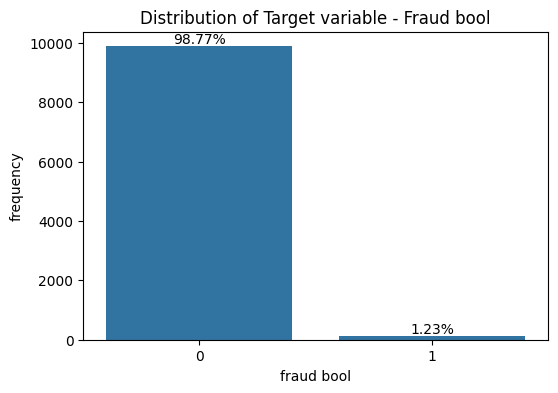

In [10]:
fig = plt.figure(figsize=(6,4))

# plot frequency of dependent variable
#ax = base['fraud_bool'].value_counts().plot(kind='bar', title='Distribution of Target variable - Fraud bool')
total_cnt = len(base)
ax = sns.countplot(x='fraud_bool', data=base)

for p in ax.patches:
    ax.annotate(f'{(p.get_height()/total_cnt)*100:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', xytext=(0,0), textcoords='offset points')

# Add titles and labels
ax.set_title('Distribution of Target variable - Fraud bool')
ax.set_xlabel('fraud bool')
ax.set_ylabel('frequency')

# Show the plot
plt.show();


In [11]:
def eda_cont_stats(feat):
    feature_stats = []

    for col in feat:
        missing_values = len(base[base[col] == -1])
        mean = base[col].mean()
        std = base[col].std()
        minimum = base[col].min()
        maximum = base[col].max()
        median = base[col].median()
        correlation = base_encoded.corr()['fraud_bool'][col]

        feature_stats.append({
            'Feature': col,
            'Missing Values': missing_values,
            'Mean': mean,
            'Standard Deviation': std,
            'Minimum': minimum,
            'Maximum': maximum,
            'Median': median,
            'Correlation': correlation
        })

    return feature_stats

# Create a DataFrame from the list of dictionaries
feature_stats = eda_cont_stats(cont_feats)
base_stats = pd.DataFrame(feature_stats)


In [12]:
base_stats

,Feature,Missing Values,Mean,Standard Deviation,Minimum,Maximum,Median,Correlation
0,name_email_similarity,0,0.490636,0.287560,1.036626e-04,0.999989,0.485970,-0.021206
1,prev_address_months_count,7085,16.285100,42.583224,-1.000000e+00,350.000000,-1.000000,-0.036180
2,current_address_months_count,54,89.754900,91.310294,-1.000000e+00,400.000000,54.000000,0.034650
3,days_since_request,0,0.965683,4.864705,5.585994e-07,74.501902,0.015008,0.008666
4,intended_balcon_amount,0,8.631497,20.097488,-1.289510e+01,110.995814,-0.838988,-0.025321
5,zip_count_4w,0,1585.025600,1017.997649,1.100000e+01,6066.000000,1268.000000,0.002712
6,velocity_6h,0,5652.157818,3027.249679,1.165740e+02,16356.364000,5295.228686,-0.024523
7,velocity_24h,0,4762.476084,1469.808500,1.500111e+03,9454.836970,4758.027155,-0.009456
8,velocity_4w,0,4858.560015,917.378550,2.983337e+03,6988.564717,4918.337969,-0.021925
9,bank_branch_count_8w,0,181.716400,455.342572,0.000000e+00,2380.000000,9.000000,-0.025007


In [13]:
def eda_continuous(feat):
    for col in feat:
        description = feature_descriptions[col]
        print(f'\033[1m{col}\033[0m\n\n{description}\n\n')

        fig, ax = plt.subplots(2, 2, figsize=(15, 10))
        plt.subplots_adjust(top=0.95, bottom=0.05, hspace=0.4, wspace=0.4)

        ax[0,0].set_title(f'Box plot for {col}')
        ax[0,0].set_xlabel(col)
        ax[0,0].boxplot(base[col], vert=False)

        kde = stats.gaussian_kde(base[col])
        x = np.linspace(base_encoded[col].min(), base_encoded[col].max(), 1000)
        ax[0,1].plot(x, kde(x), color='red')
        # Define bins for the histograms
        ax[0,1].hist(base_encoded[col], bins=20, density=True, alpha=0.75, color='skyblue', edgecolor='black')
        ax[0,1].set_title(f'{col}')
        ax[0,1].set_xlabel(col)
        ax[0,1].set_ylabel('Density')
        ax[0,1].set_xlim(0, max(base_encoded[col]))

        # KDE plot of numerical features
        sns.kdeplot(data=base_encoded[base_encoded[target_feat]==0], x=col, fill=True, linewidth=2, ax=ax[1, 0], label='0')
        sns.kdeplot(data=base_encoded[base_encoded[target_feat]==1], x=col, fill=True, linewidth=2, ax=ax[1, 0], label='1')
        ax[1,0].set_xlim(0, max(base_encoded[col]))
        ax[1,1].axis('off')
        # Display the plot
        plt.tight_layout()
        plt.show()


name_email_similarity

Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges between [0, 1].




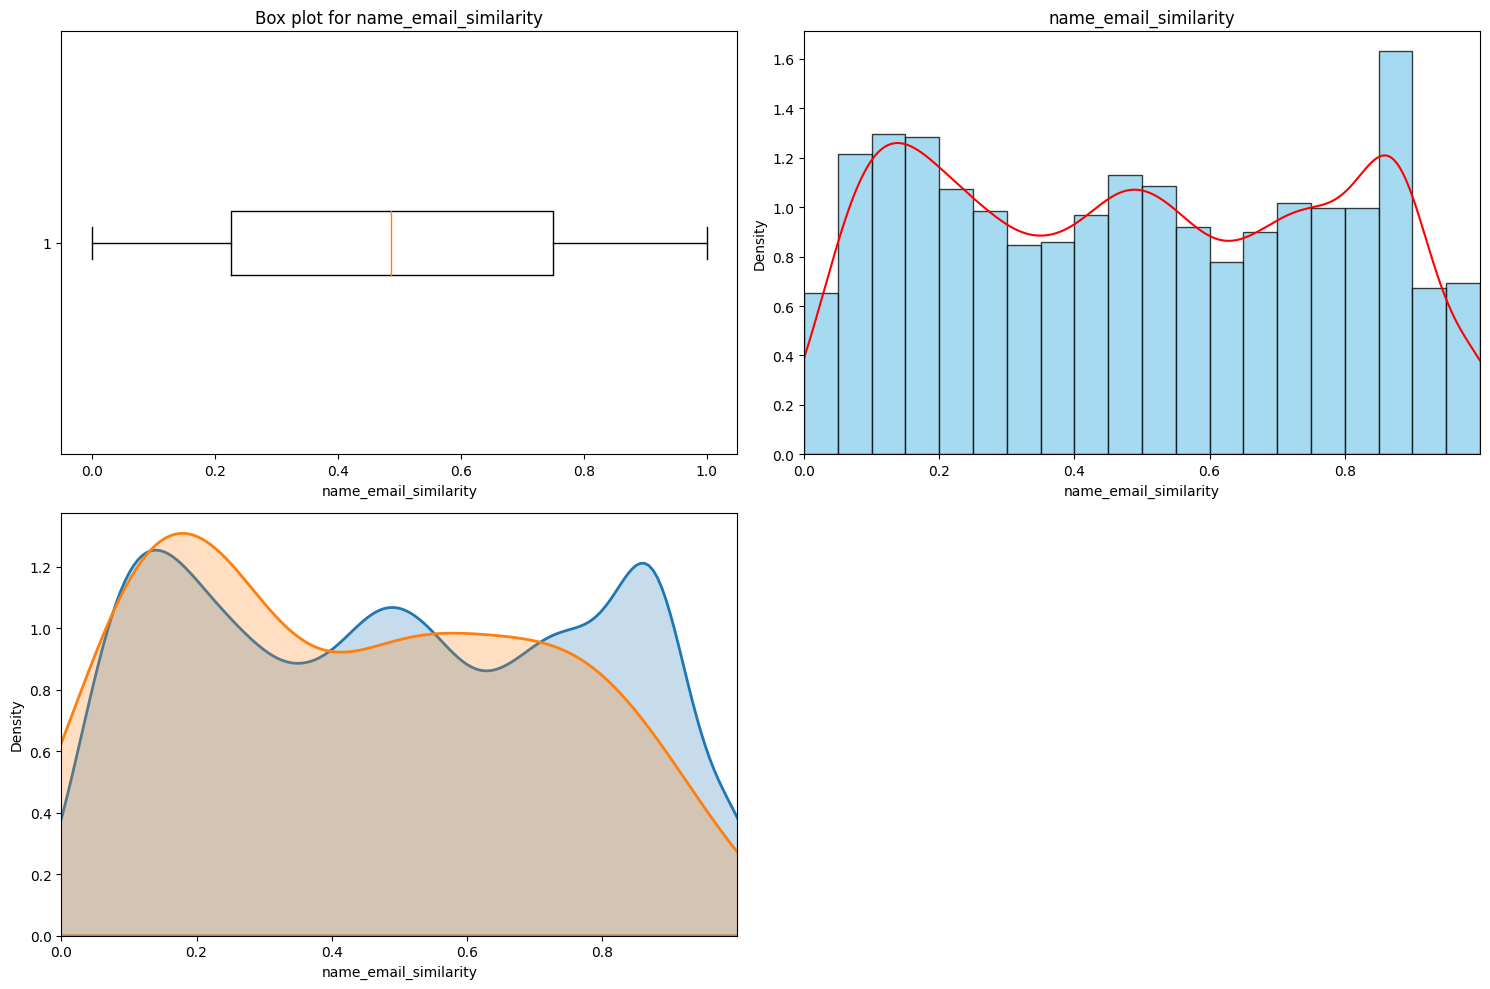

prev_address_months_count

Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [−1, 380] months (-1 is a missing value).




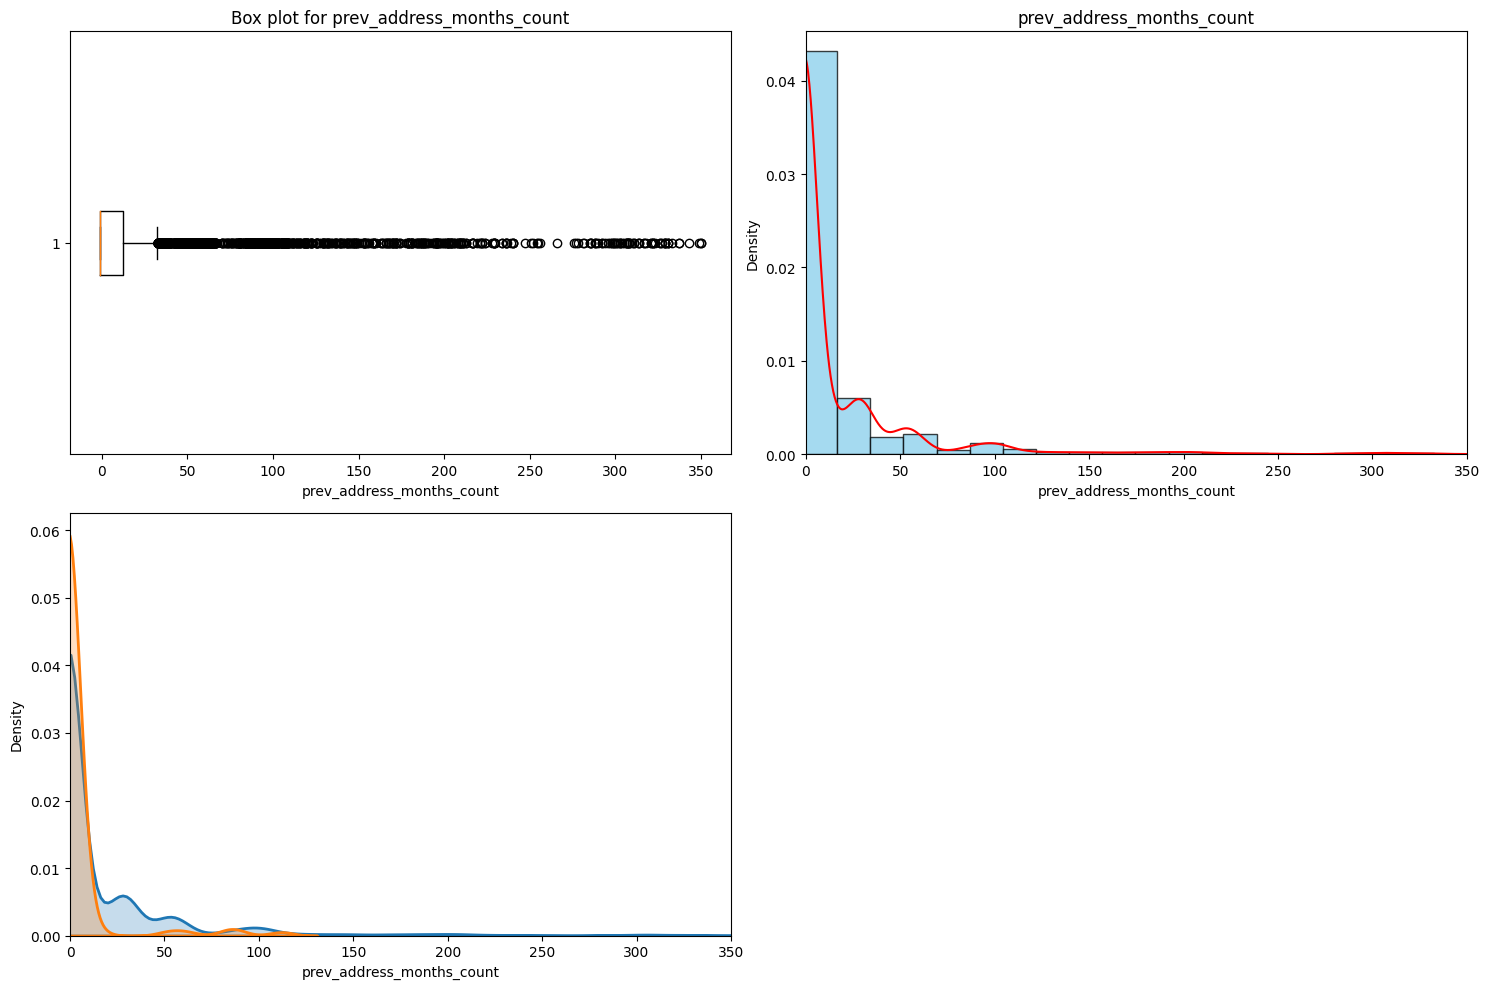

current_address_months_count

Months in currently registered address of the applicant. Ranges between [−1, 429] months (-1 is a missing value).




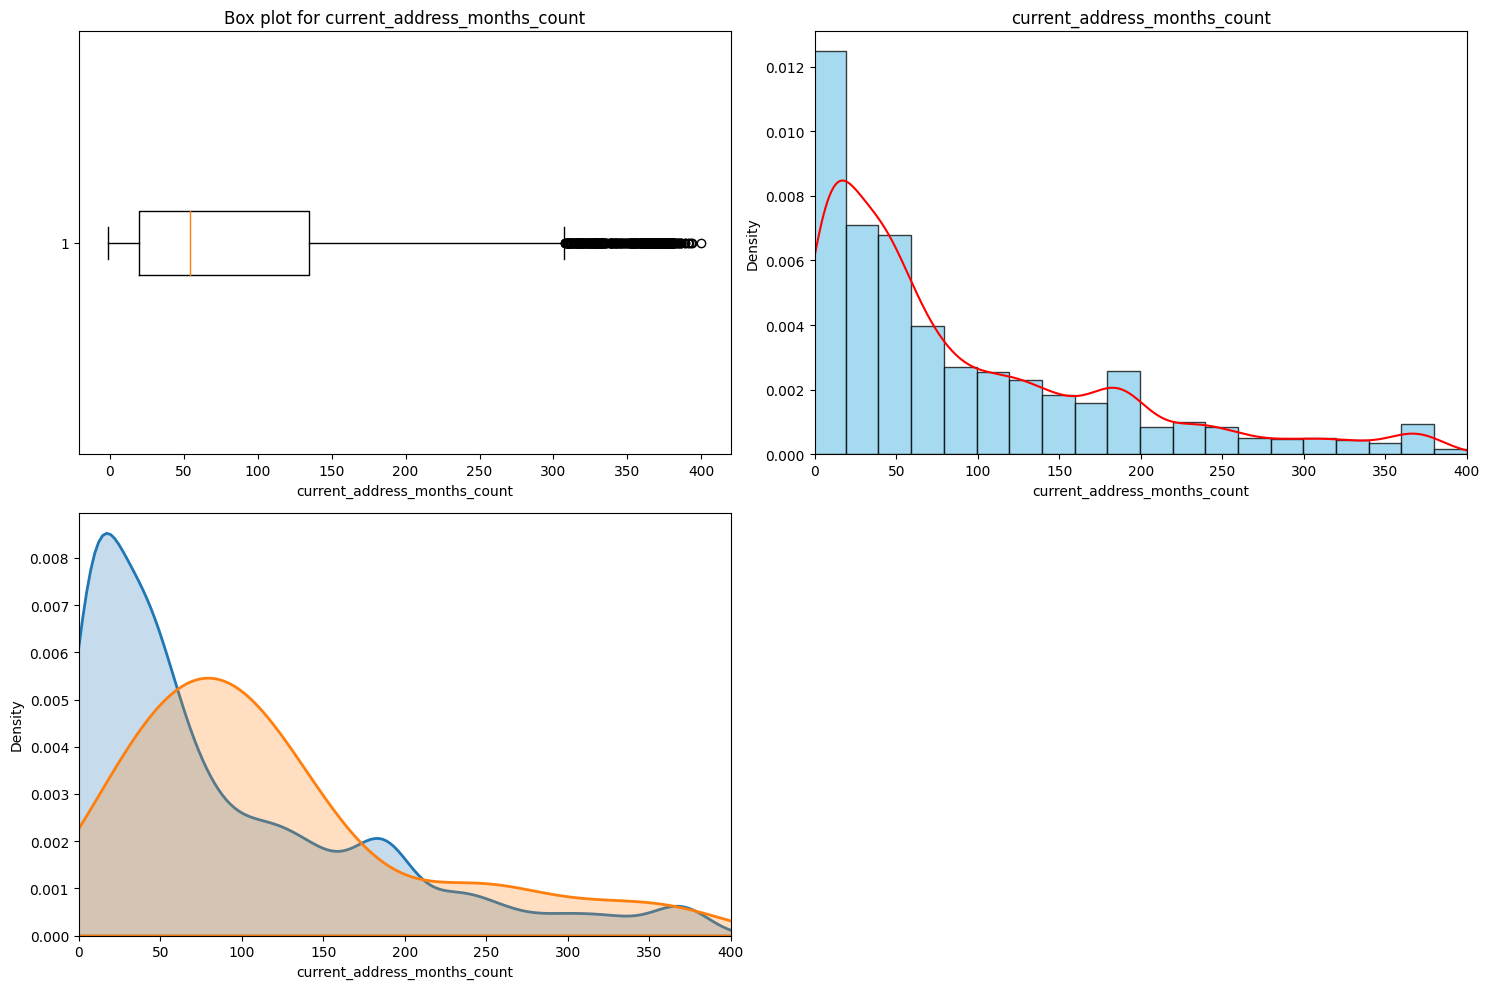

days_since_request

Number of days passed since application was done. Ranges between [0, 79] days.




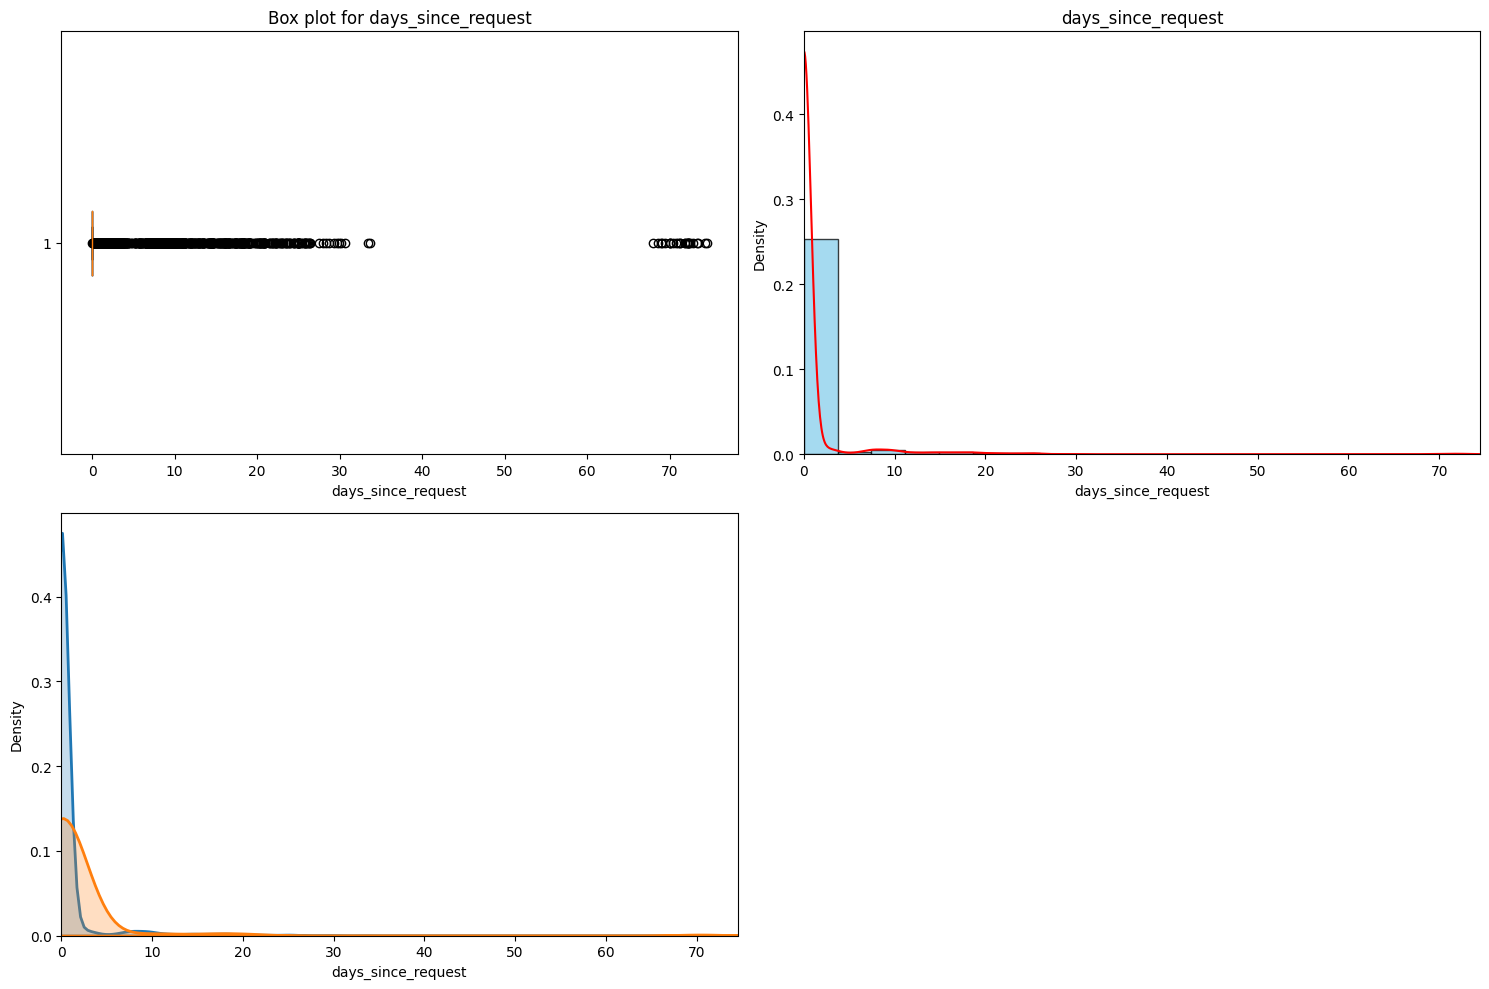

intended_balcon_amount

Initial transferred amount for application. Ranges between [−16, 114] (negatives are missing values).




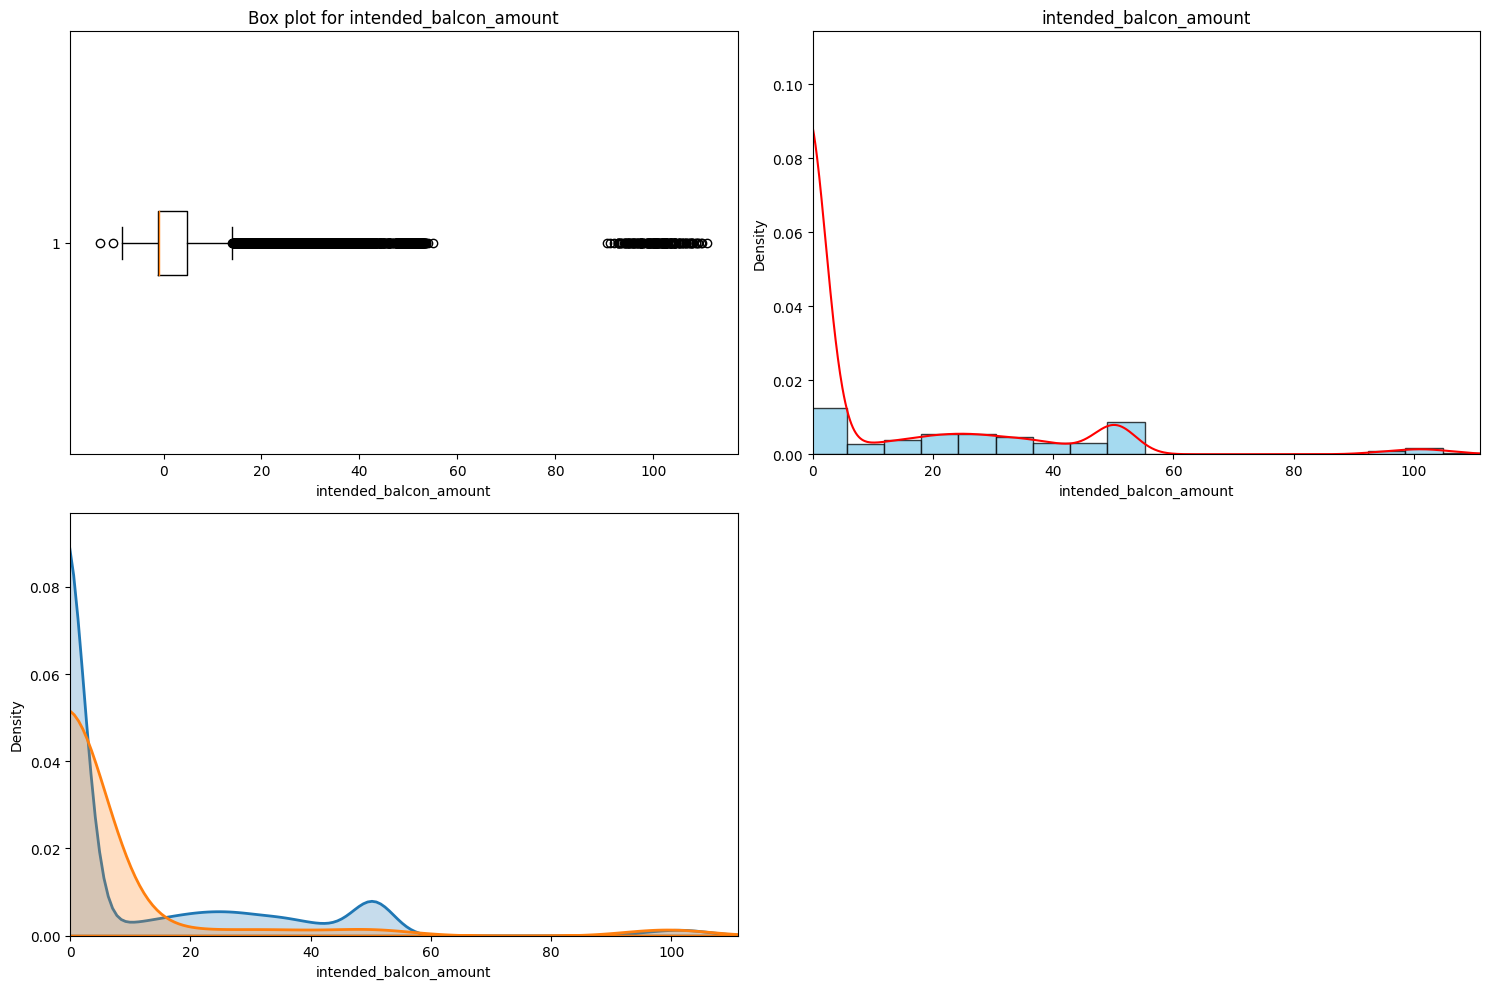

zip_count_4w

Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].




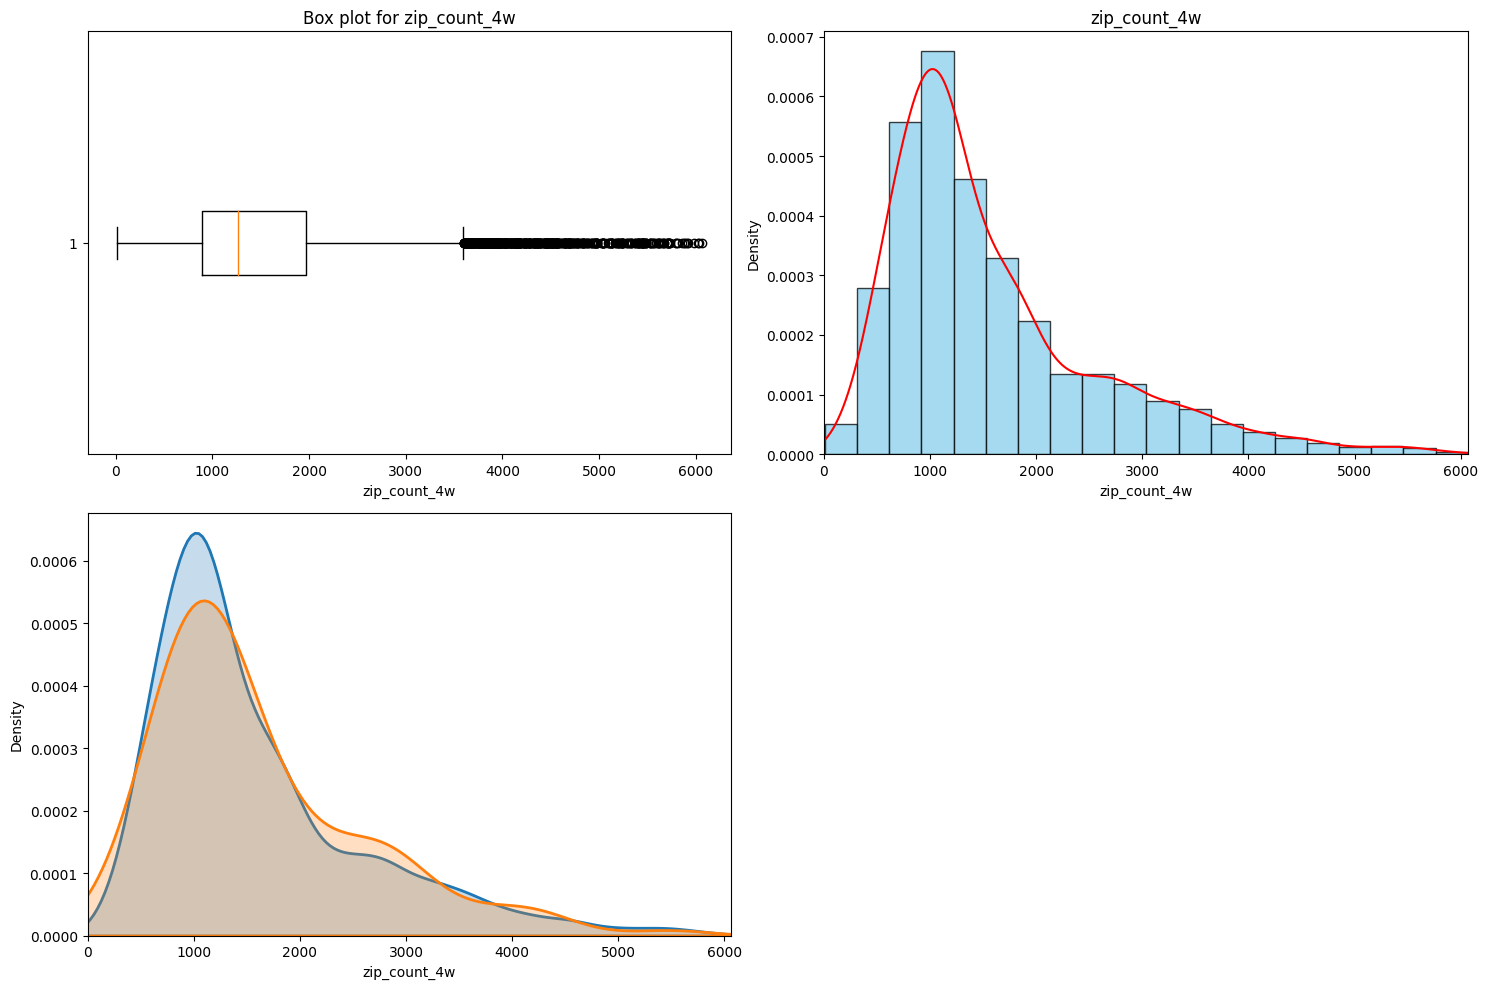

velocity_6h

Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [−175, 16818].




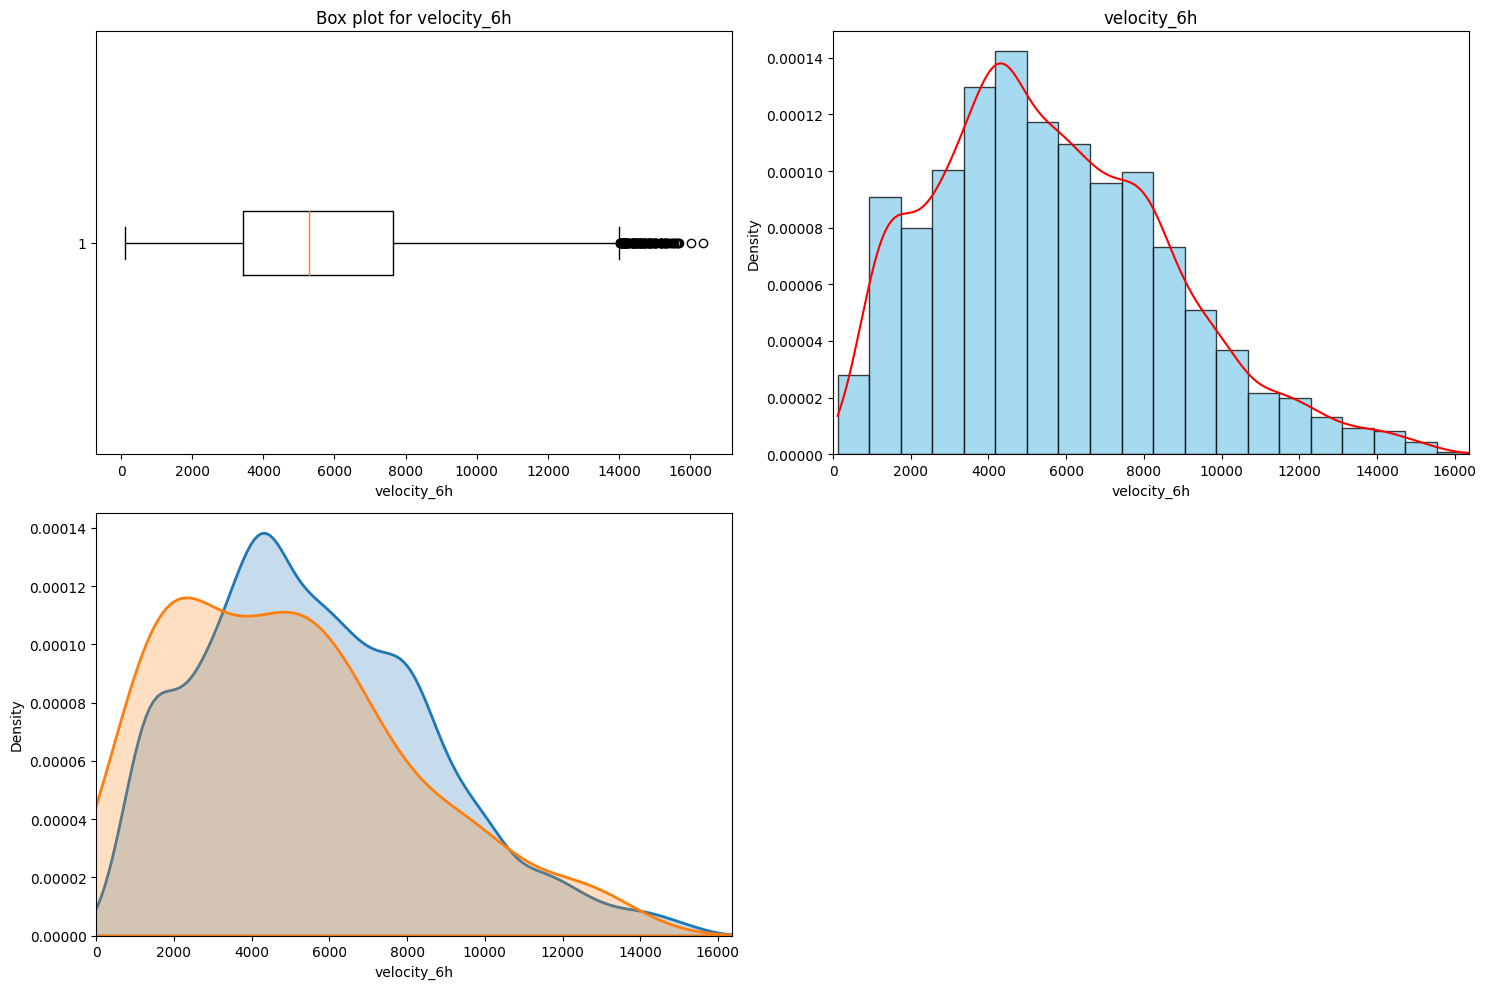

velocity_24h

Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].




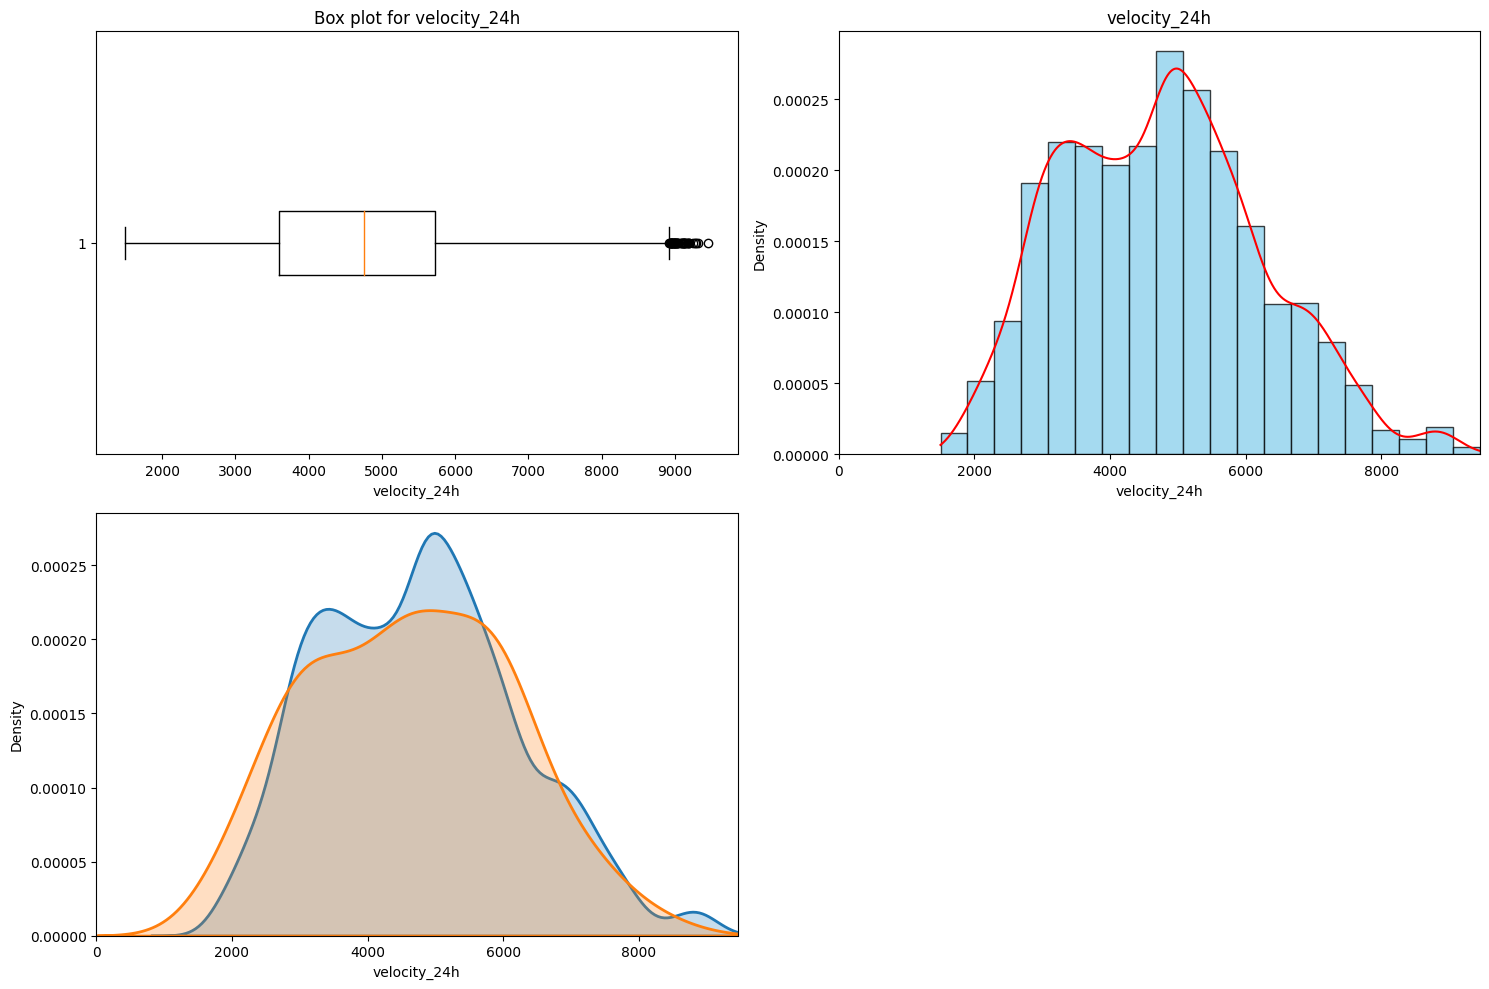

velocity_4w

Velocity of total applications made in last 4 weeks, i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].




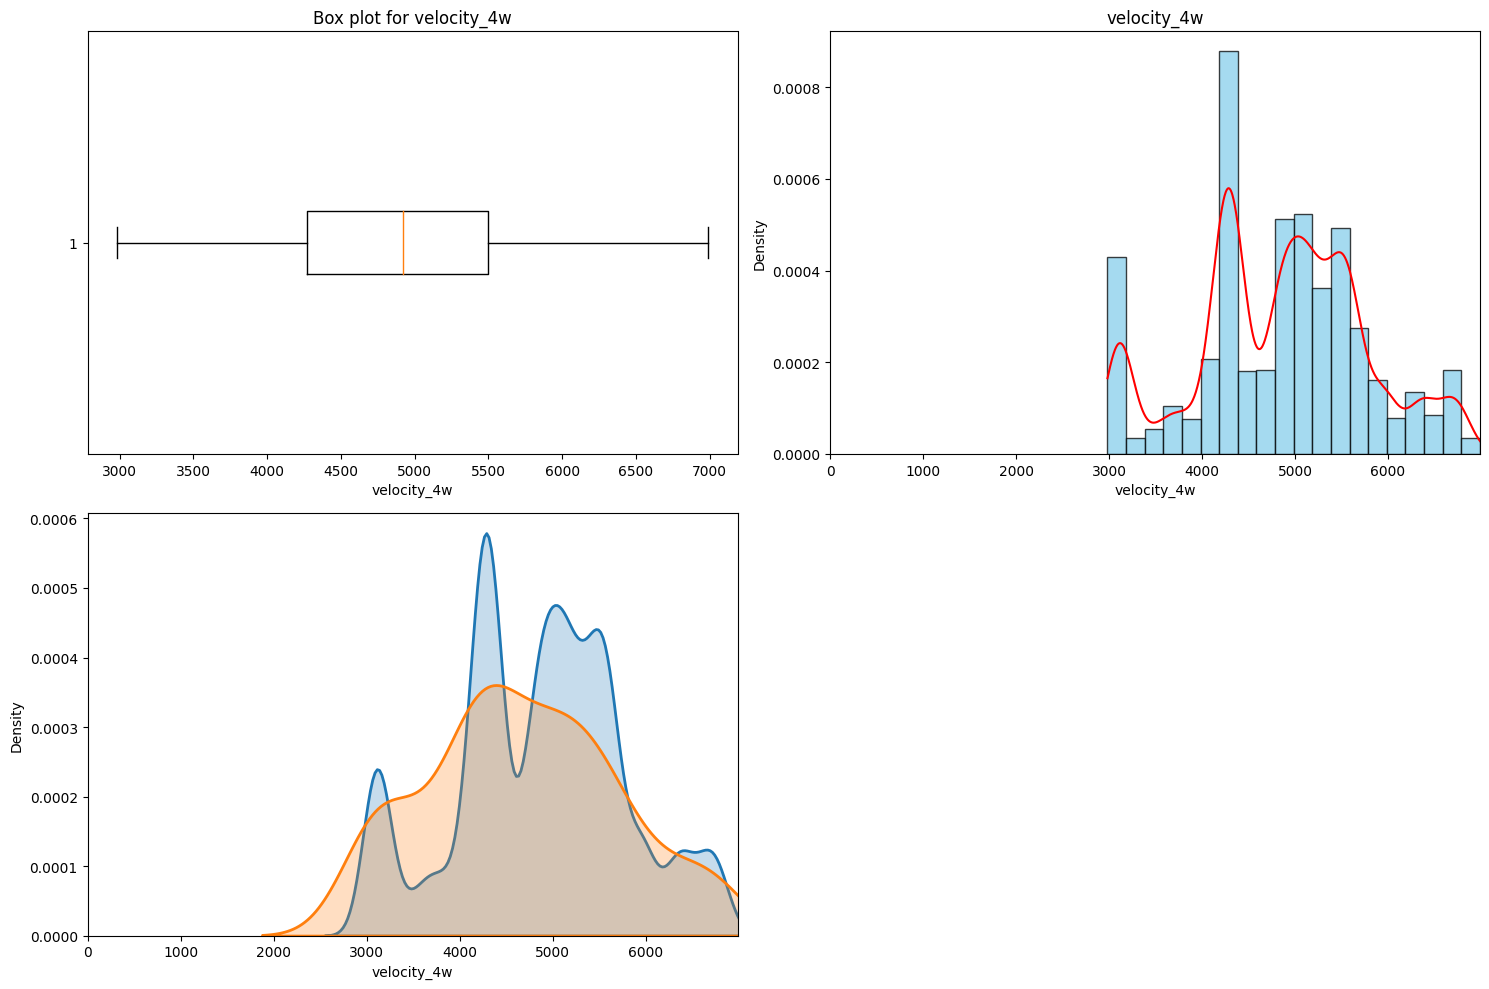

bank_branch_count_8w

Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].




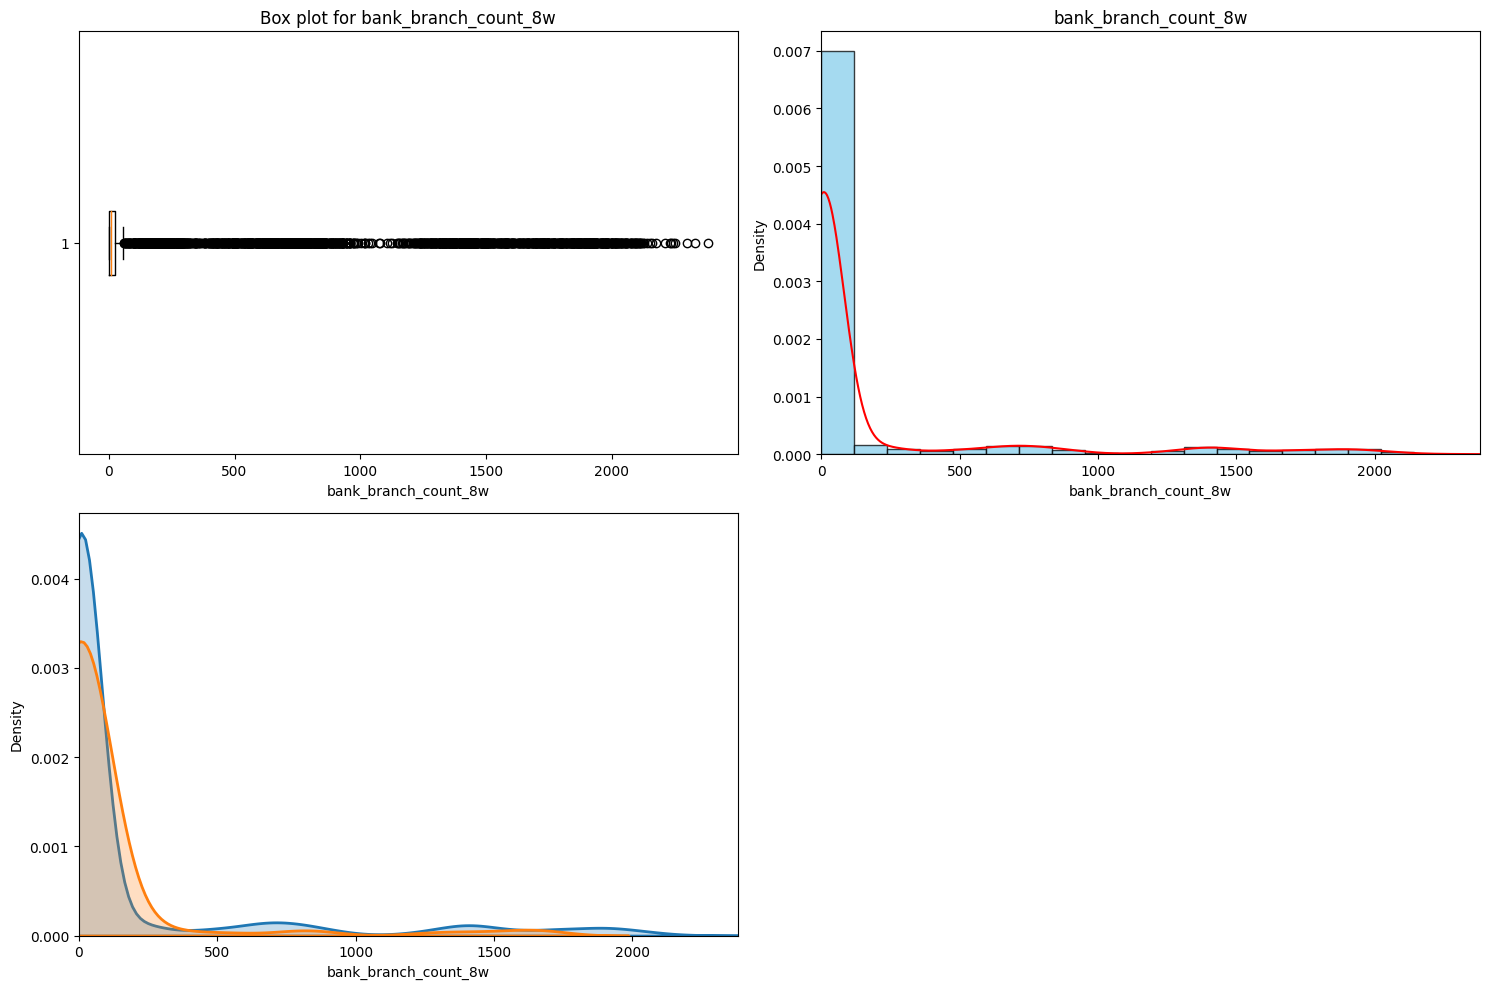

date_of_birth_distinct_emails_4w

Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].




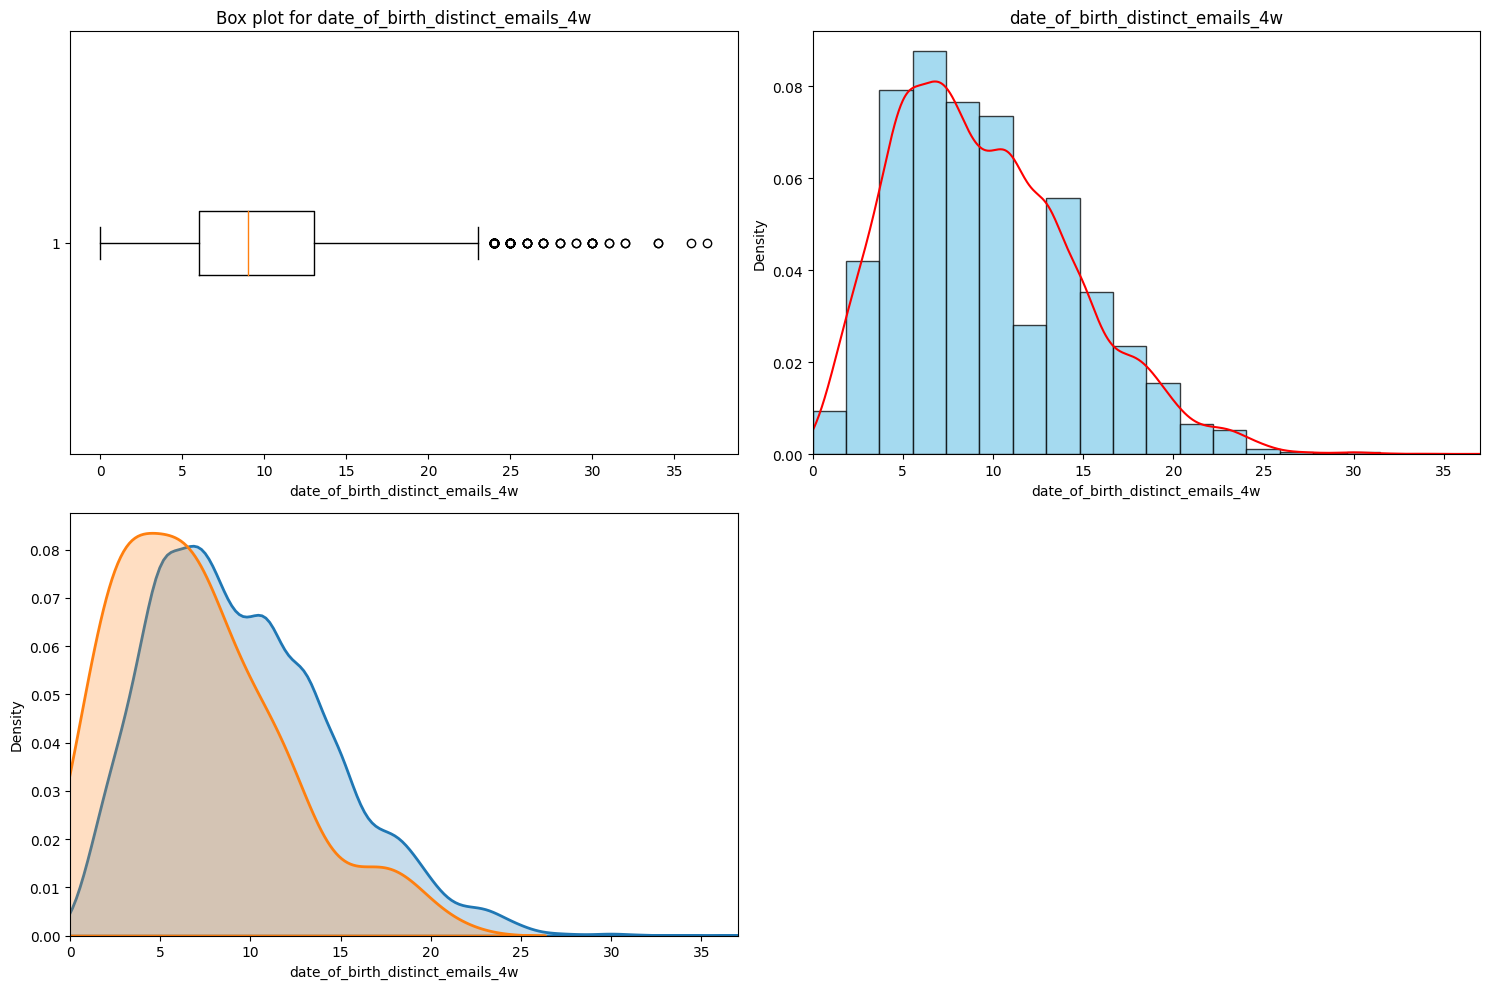

credit_risk_score

Internal score of application risk. Ranges between [−191, 389].




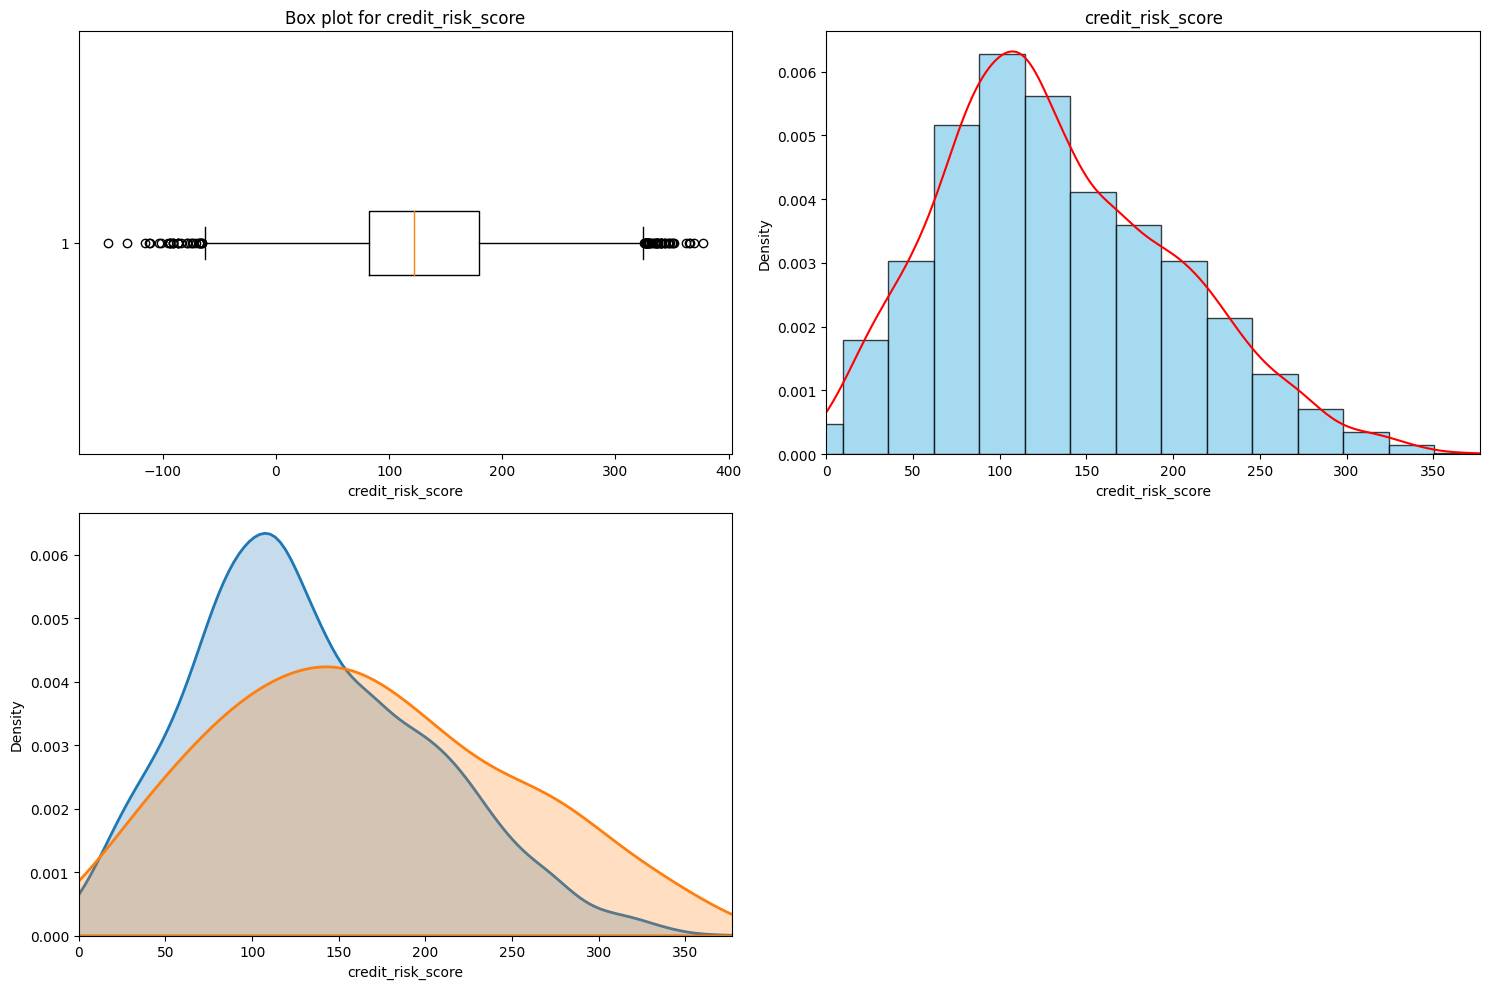

bank_months_count

How old is previous account (if held) in months. Ranges between [−1, 32] months (-1 is a missing value).




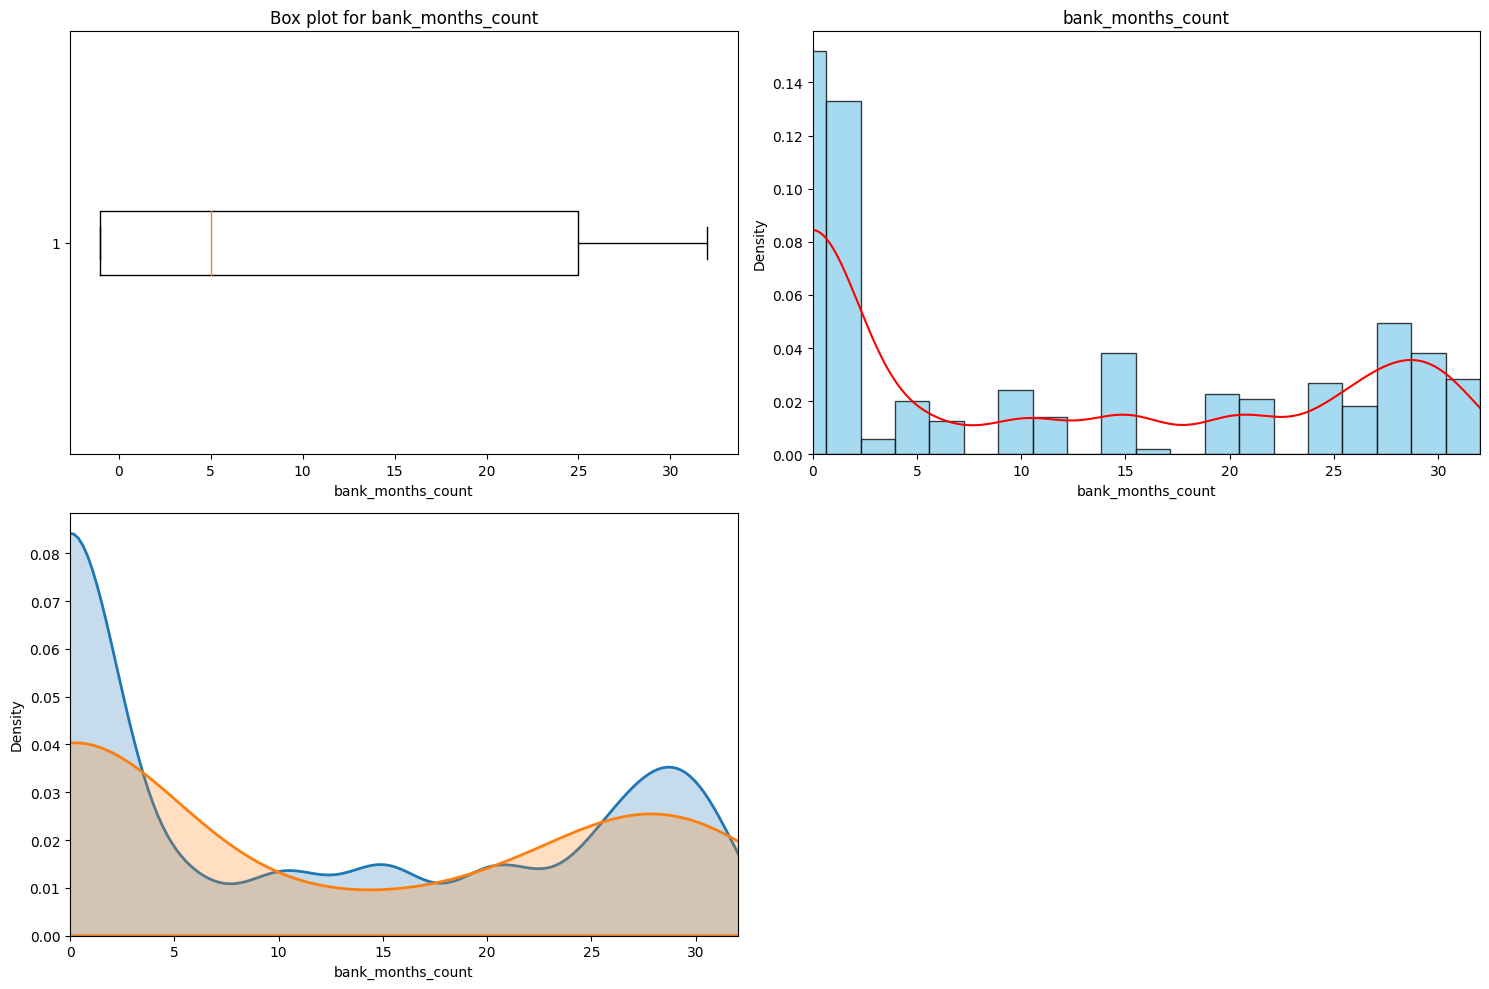

session_length_in_minutes

Length of user session in banking website in minutes. Ranges between [−1, 107] minutes (-1 is a missing value).




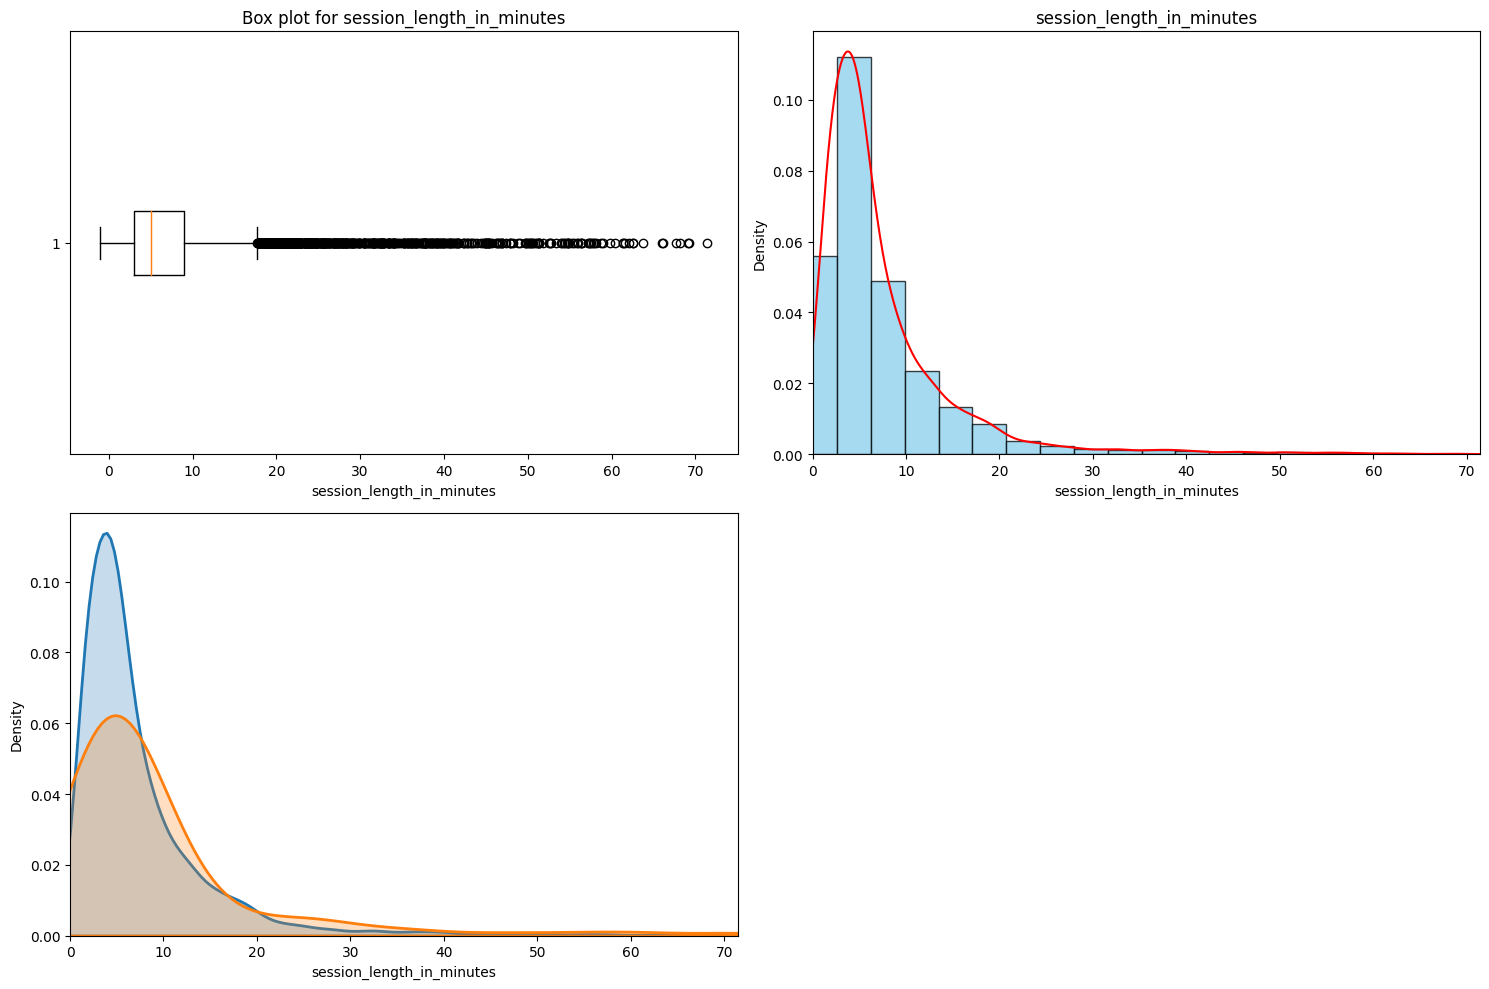

income

Annual income of the applicant (in decile form). Ranges between [0.1, 0.9].




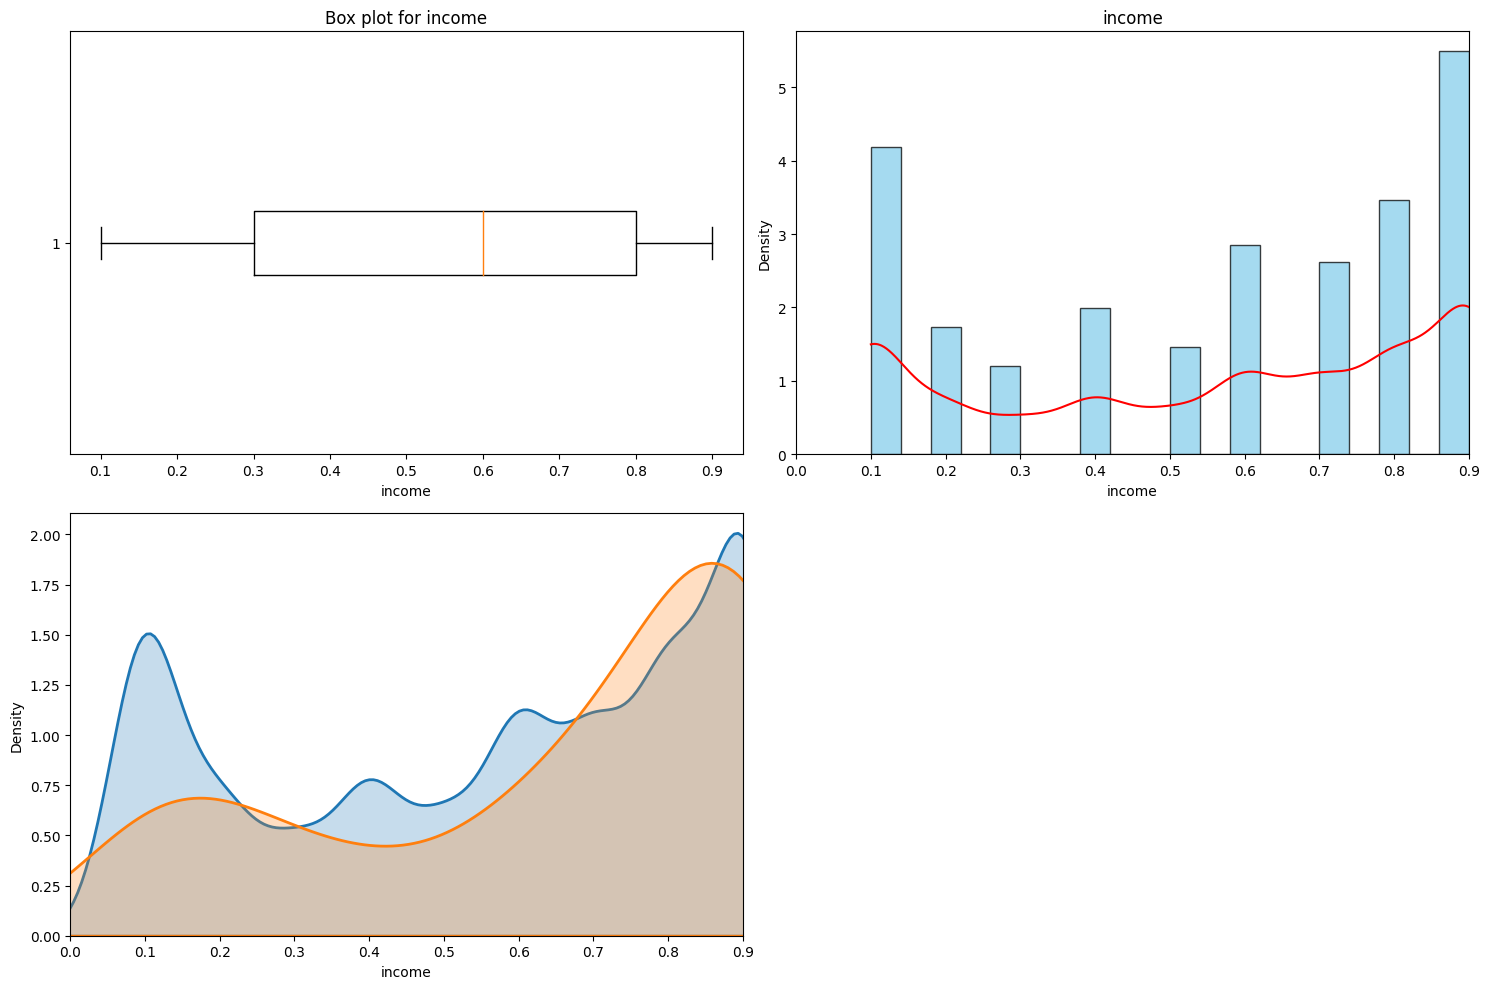

In [14]:
eda_continuous(cont_feats)

payment_type

Credit payment plan type. 5 possible (annonymized) values.




,0
Feature,payment_type
Missing Values,0
Correlation,0.018938


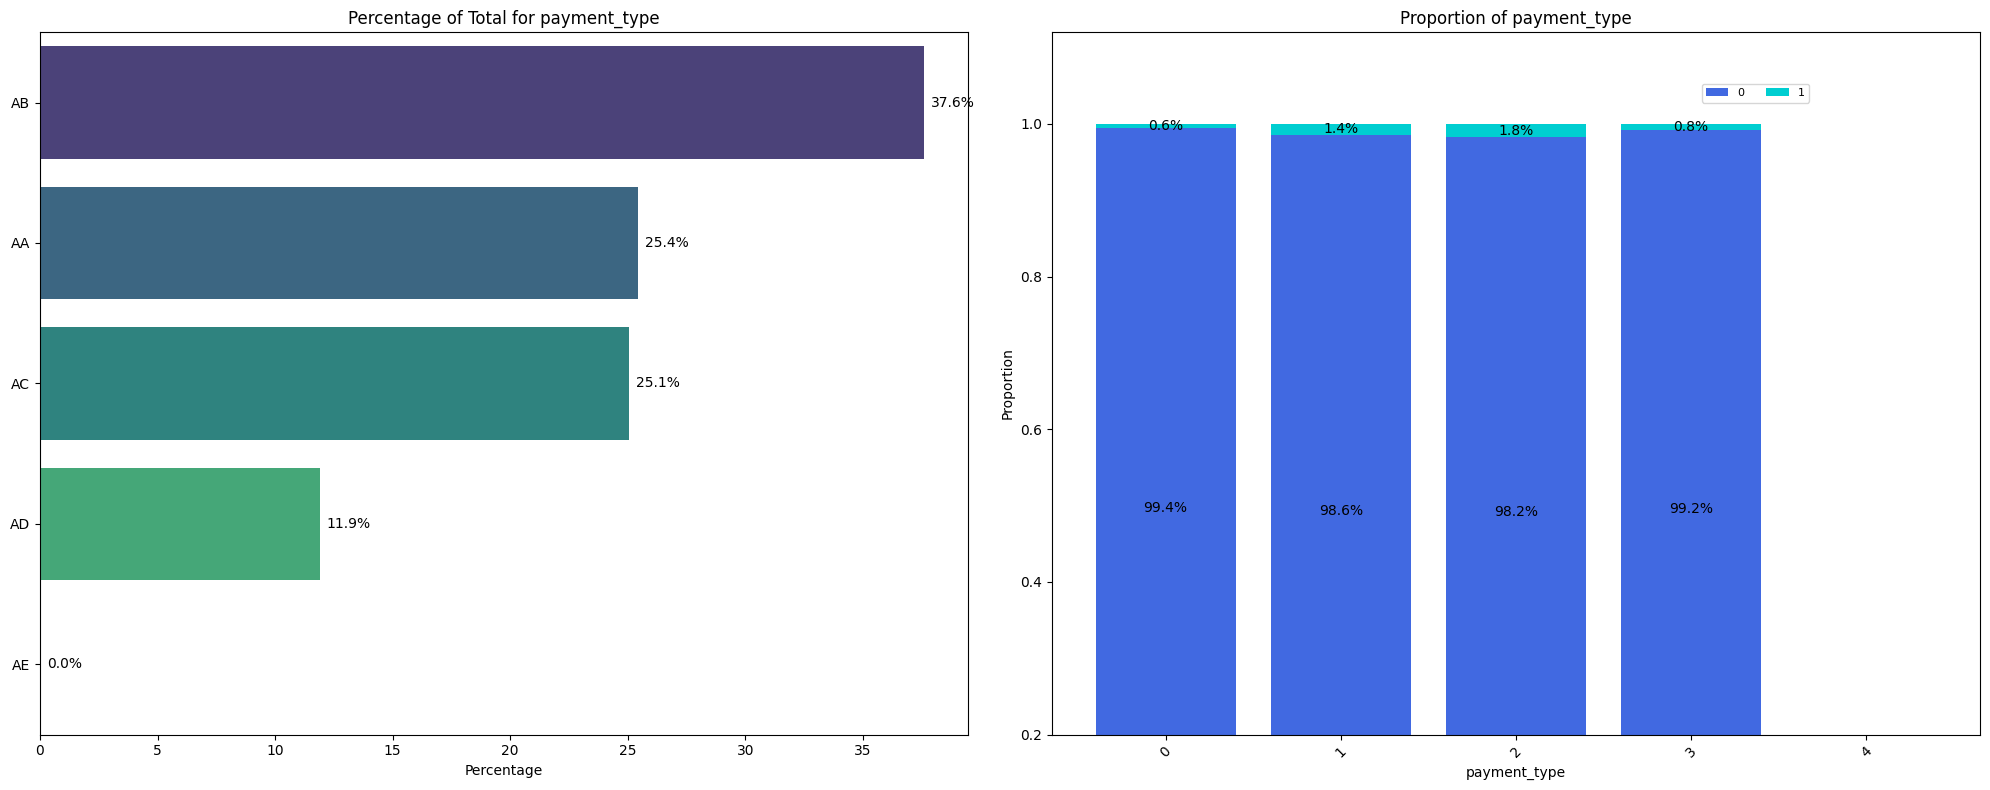

employment_status

Employment status of the applicant. 7 possible (annonymized) values.




,0
Feature,employment_status
Missing Values,0
Correlation,-0.016106


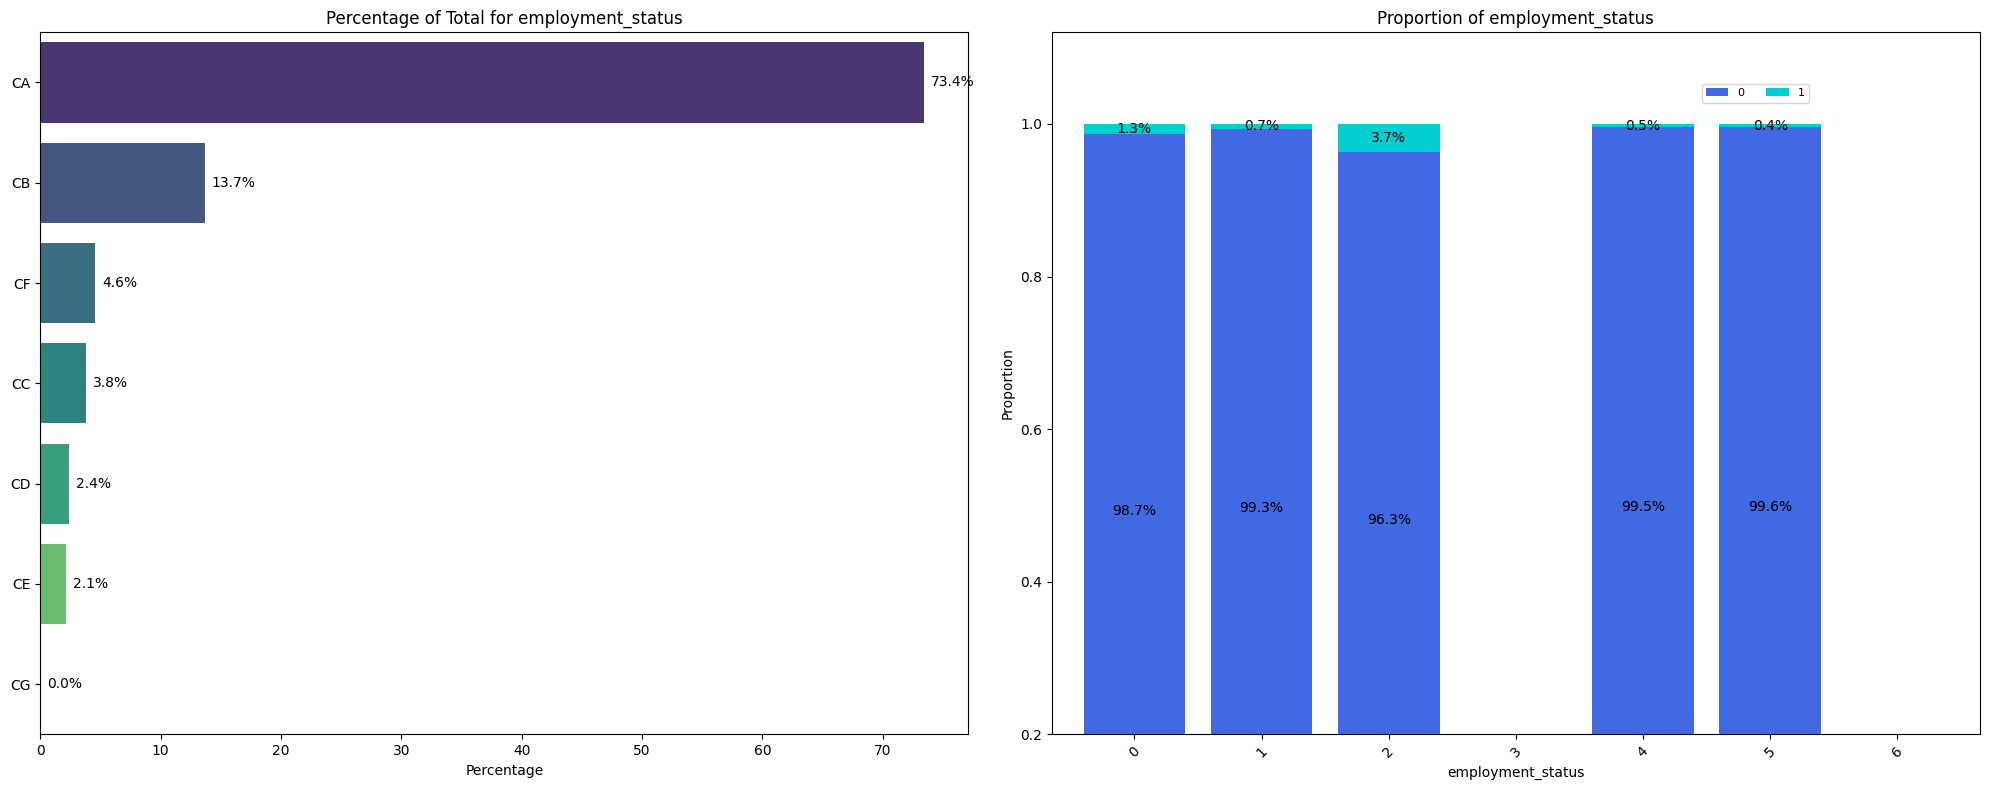

housing_status

Current residential status for applicant. 7 possible (annonymized) values.




,0
Feature,housing_status
Missing Values,0
Correlation,-0.072364


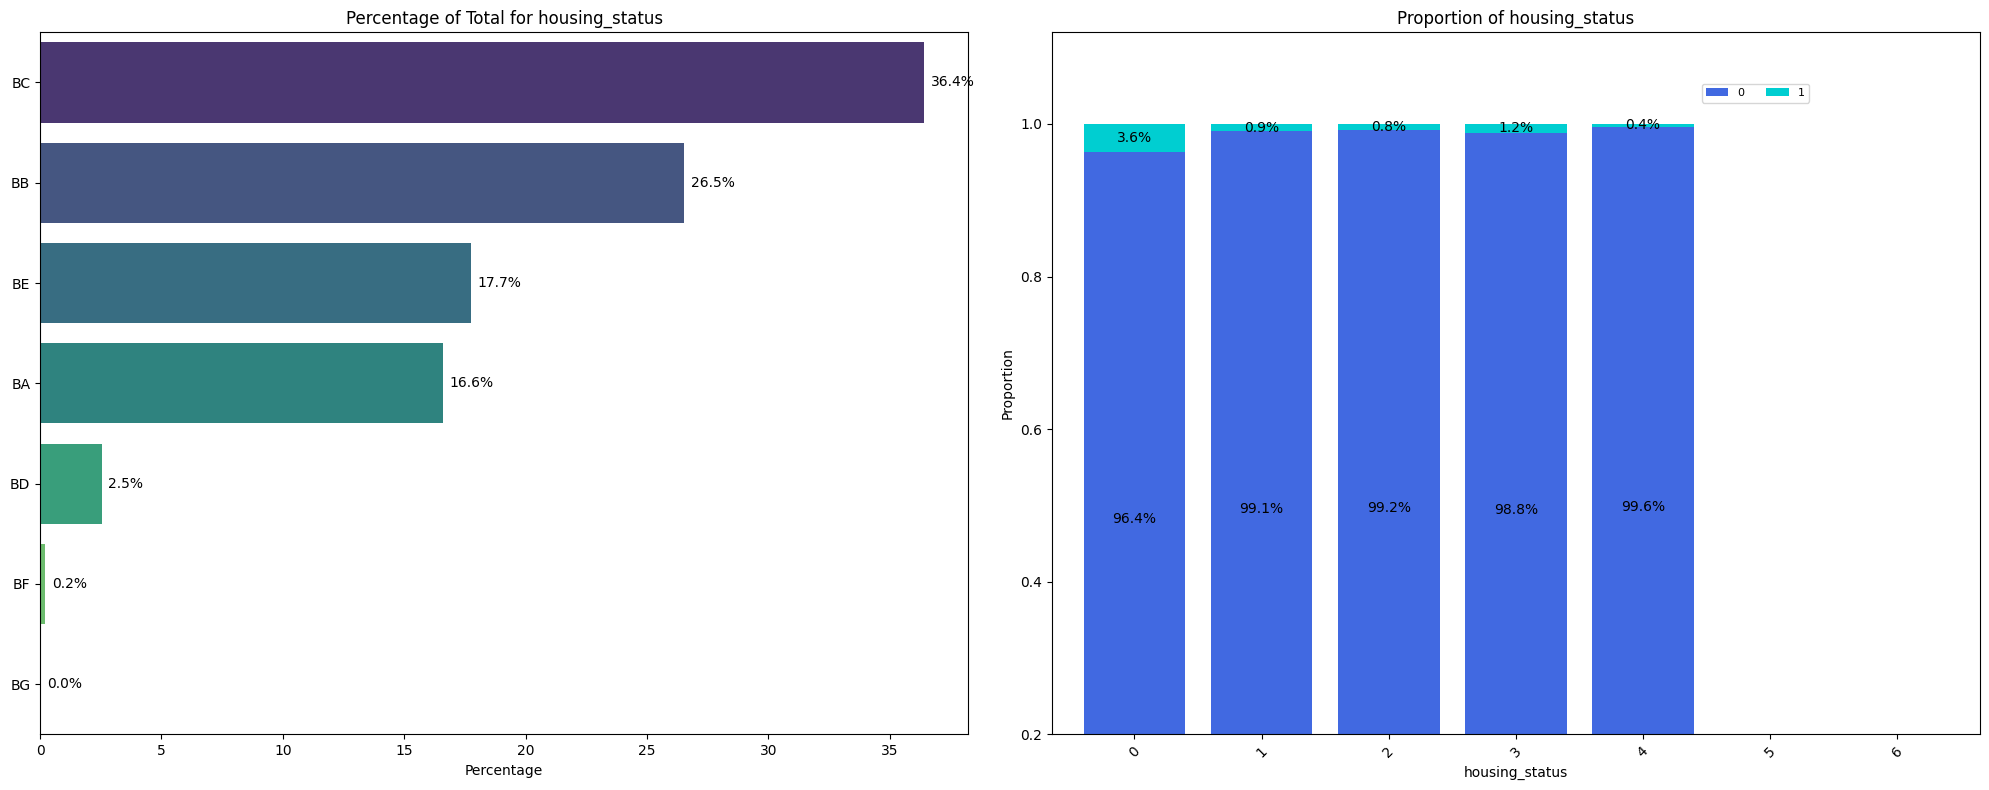

source

Online source of application. Either browser (INTERNET) or app (TELEAPP).




,0
Feature,source
Missing Values,0
Correlation,-0.009635


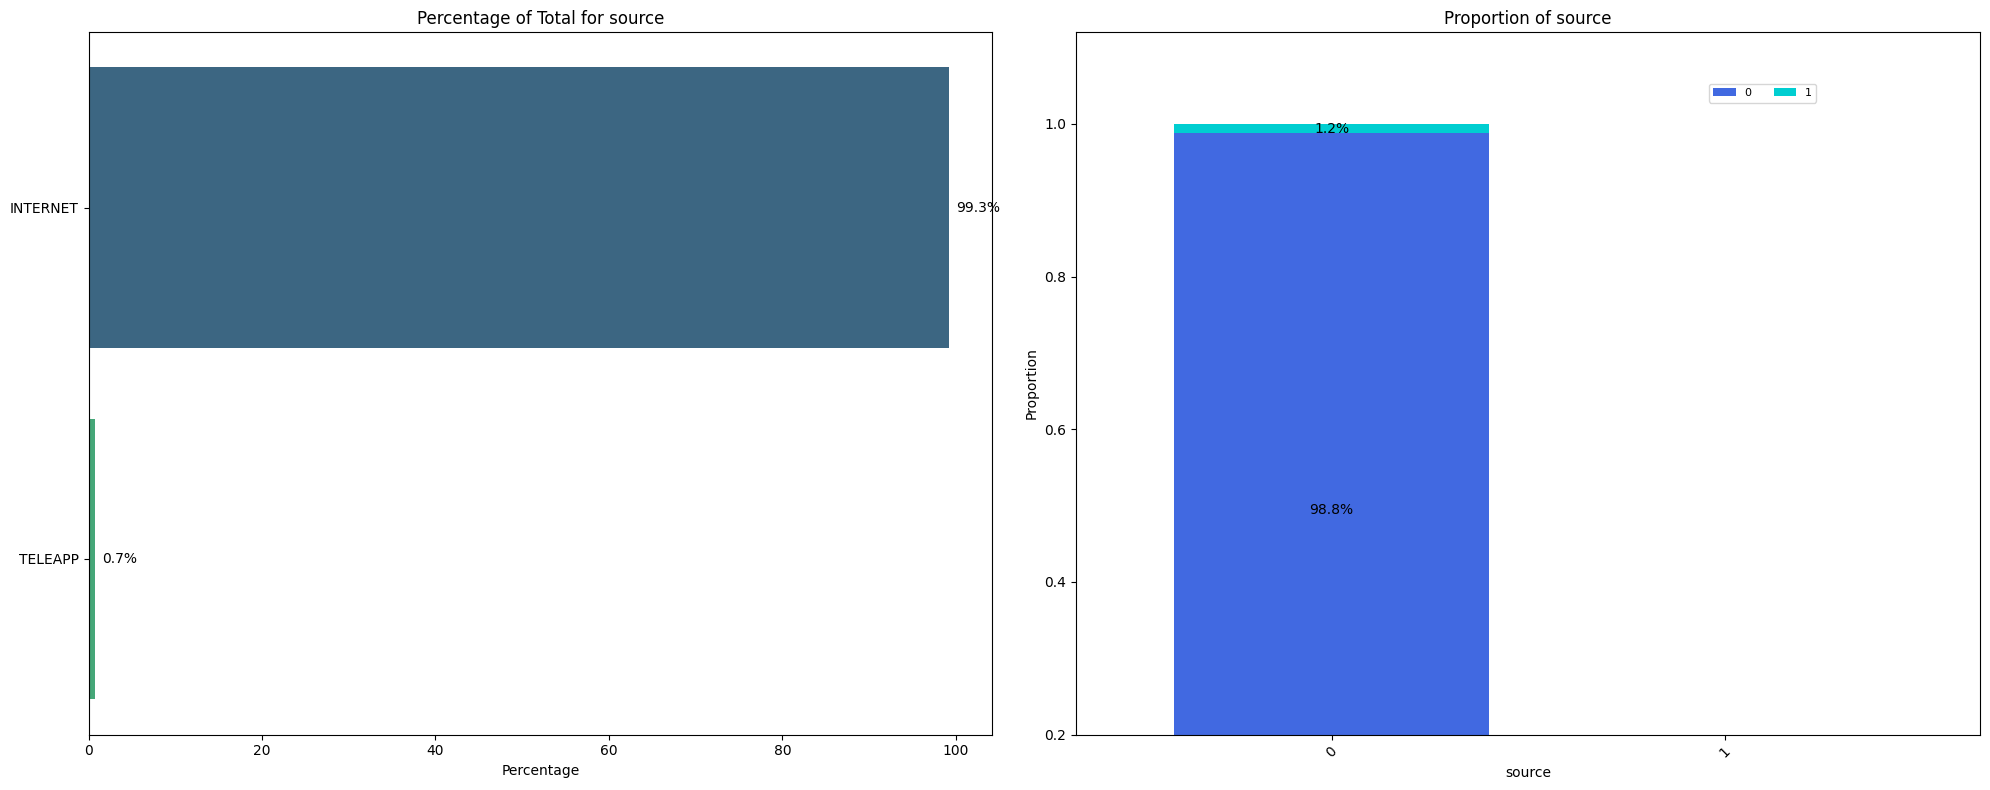

device_os

Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.




,0
Feature,device_os
Missing Values,0
Correlation,0.055747


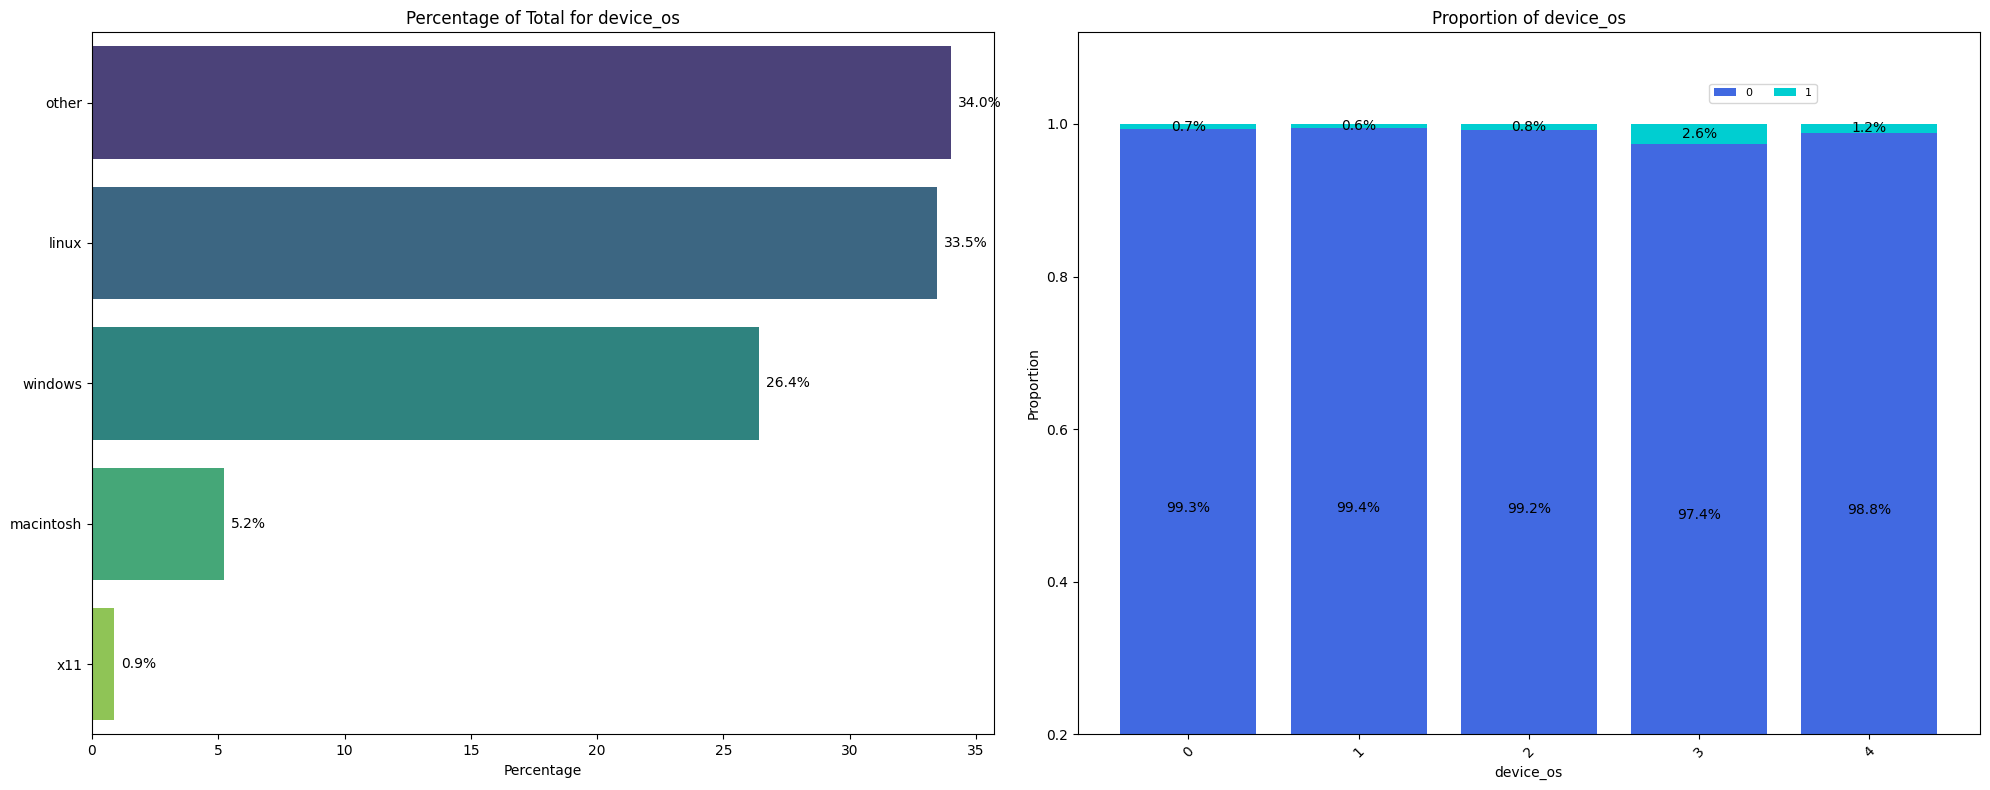

customer_age

Applicant’s age in years, rounded to the decade. Ranges between [10, 90] years.




,0
Feature,customer_age
Missing Values,0
Correlation,0.057794


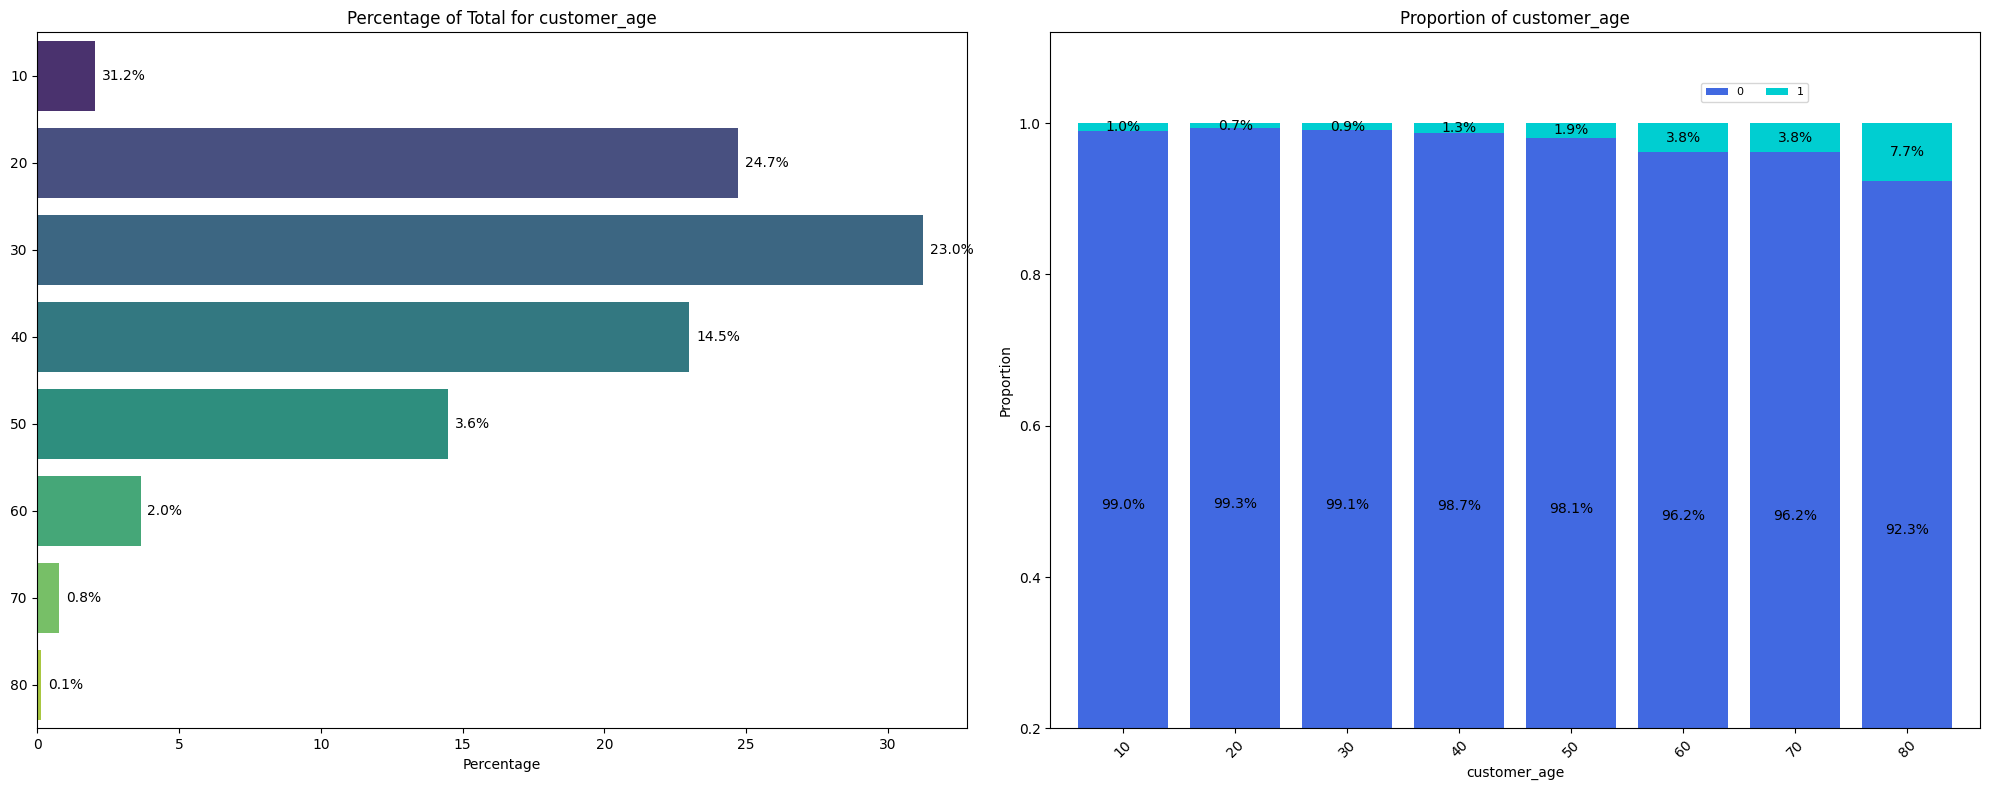

email_is_free

Domain of application email (either free or paid).




,0
Feature,email_is_free
Missing Values,0
Correlation,0.036515


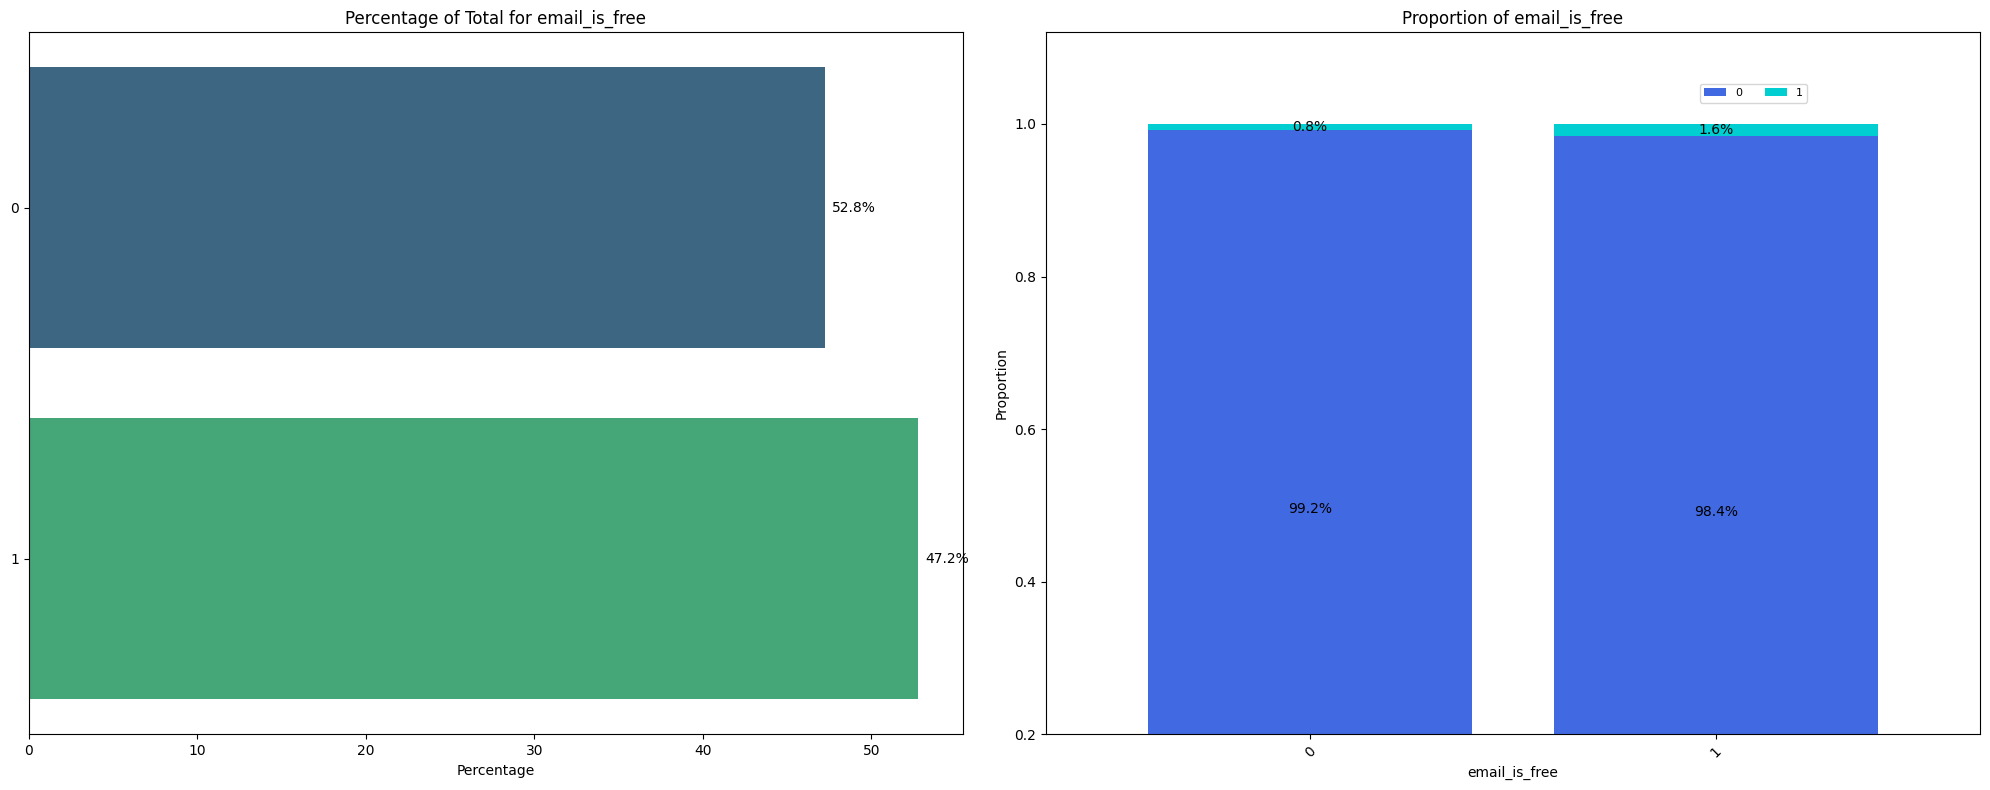

phone_home_valid

Validity of provided home phone.




,0
Feature,phone_home_valid
Missing Values,0
Correlation,-0.016427


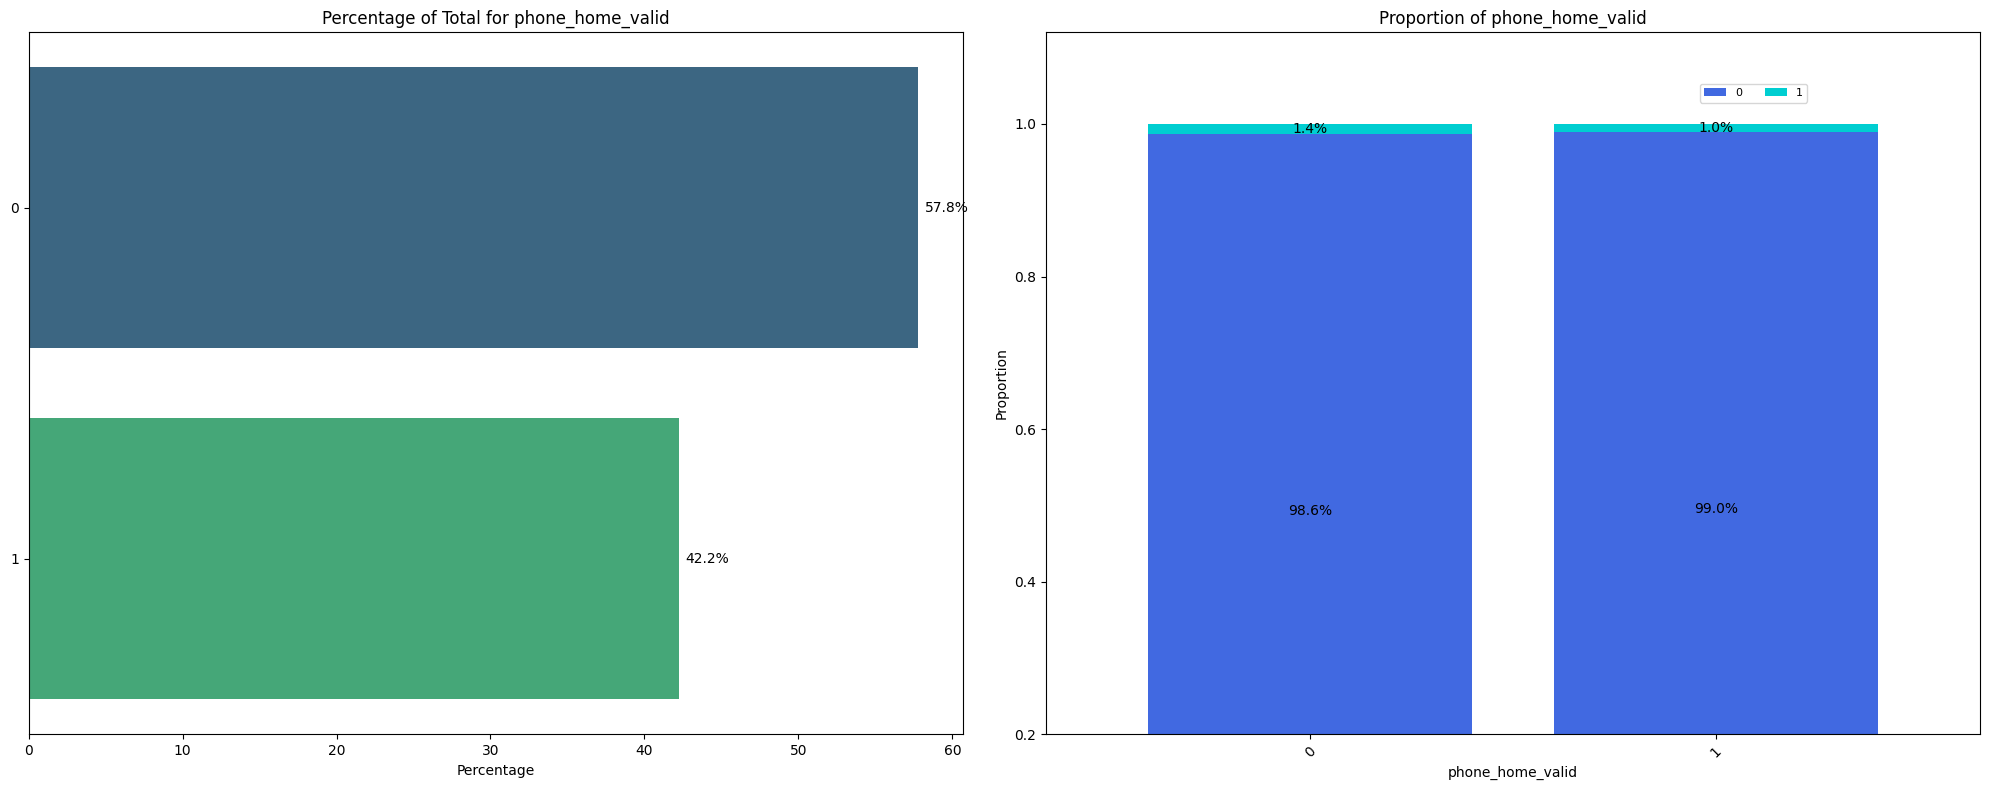

phone_mobile_valid

Validity of provided mobile phone.




,0
Feature,phone_mobile_valid
Missing Values,0
Correlation,-0.015526


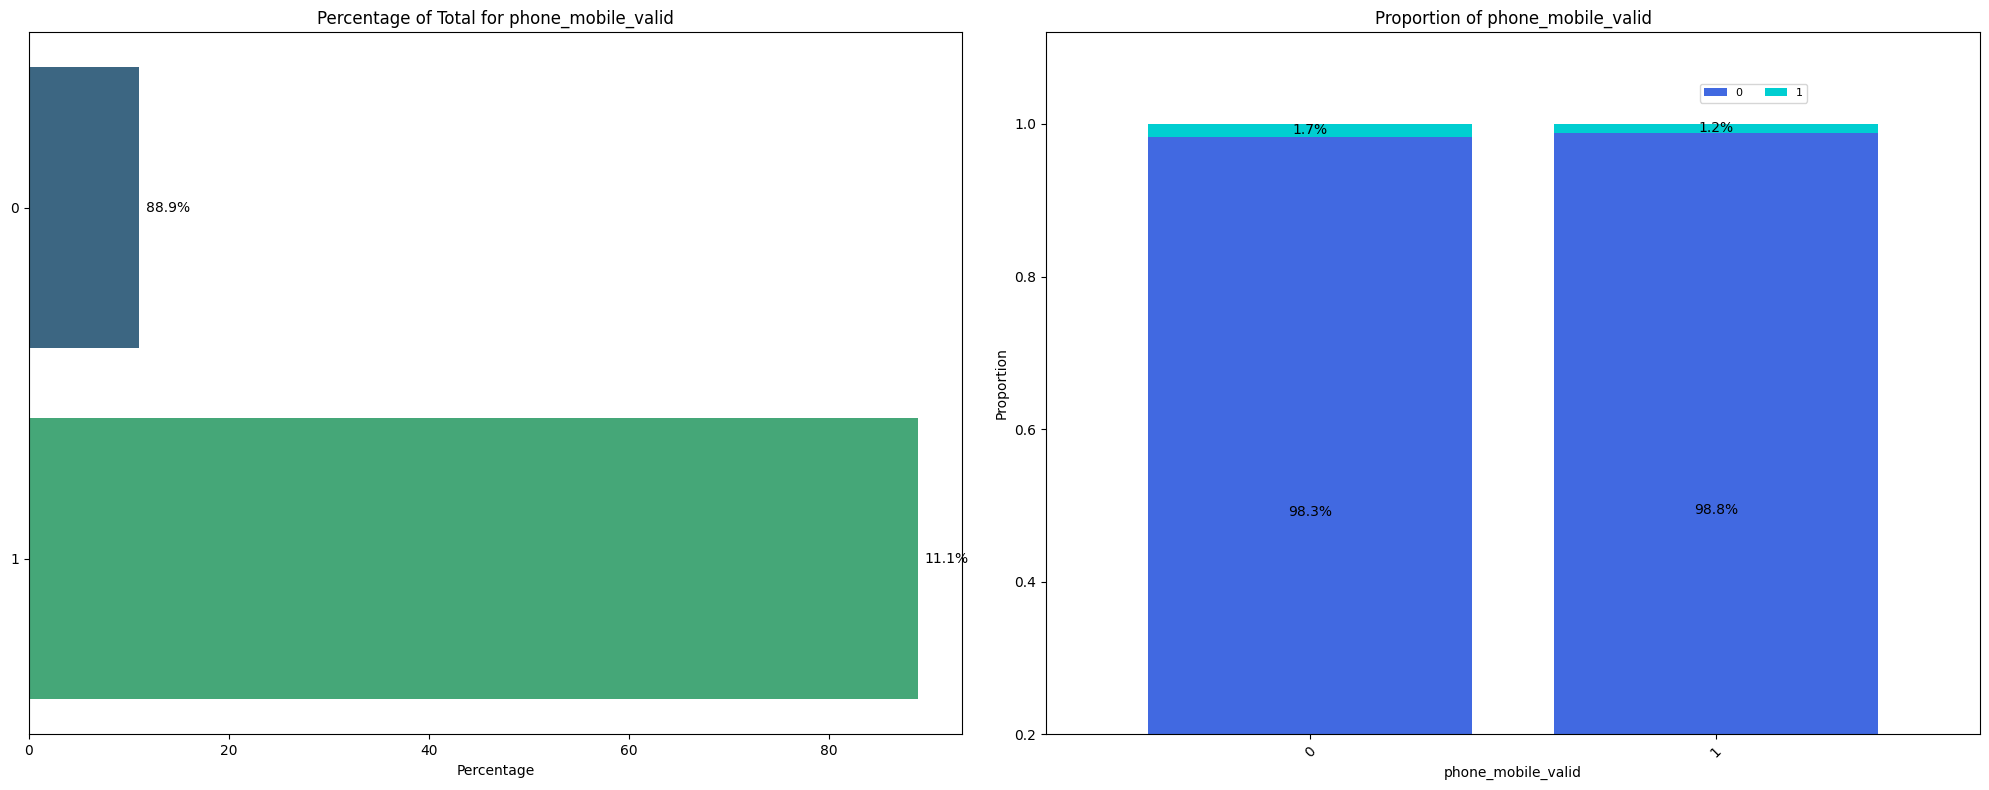

has_other_cards

If applicant has other cards from the same banking company.




,0
Feature,has_other_cards
Missing Values,0
Correlation,-0.037863


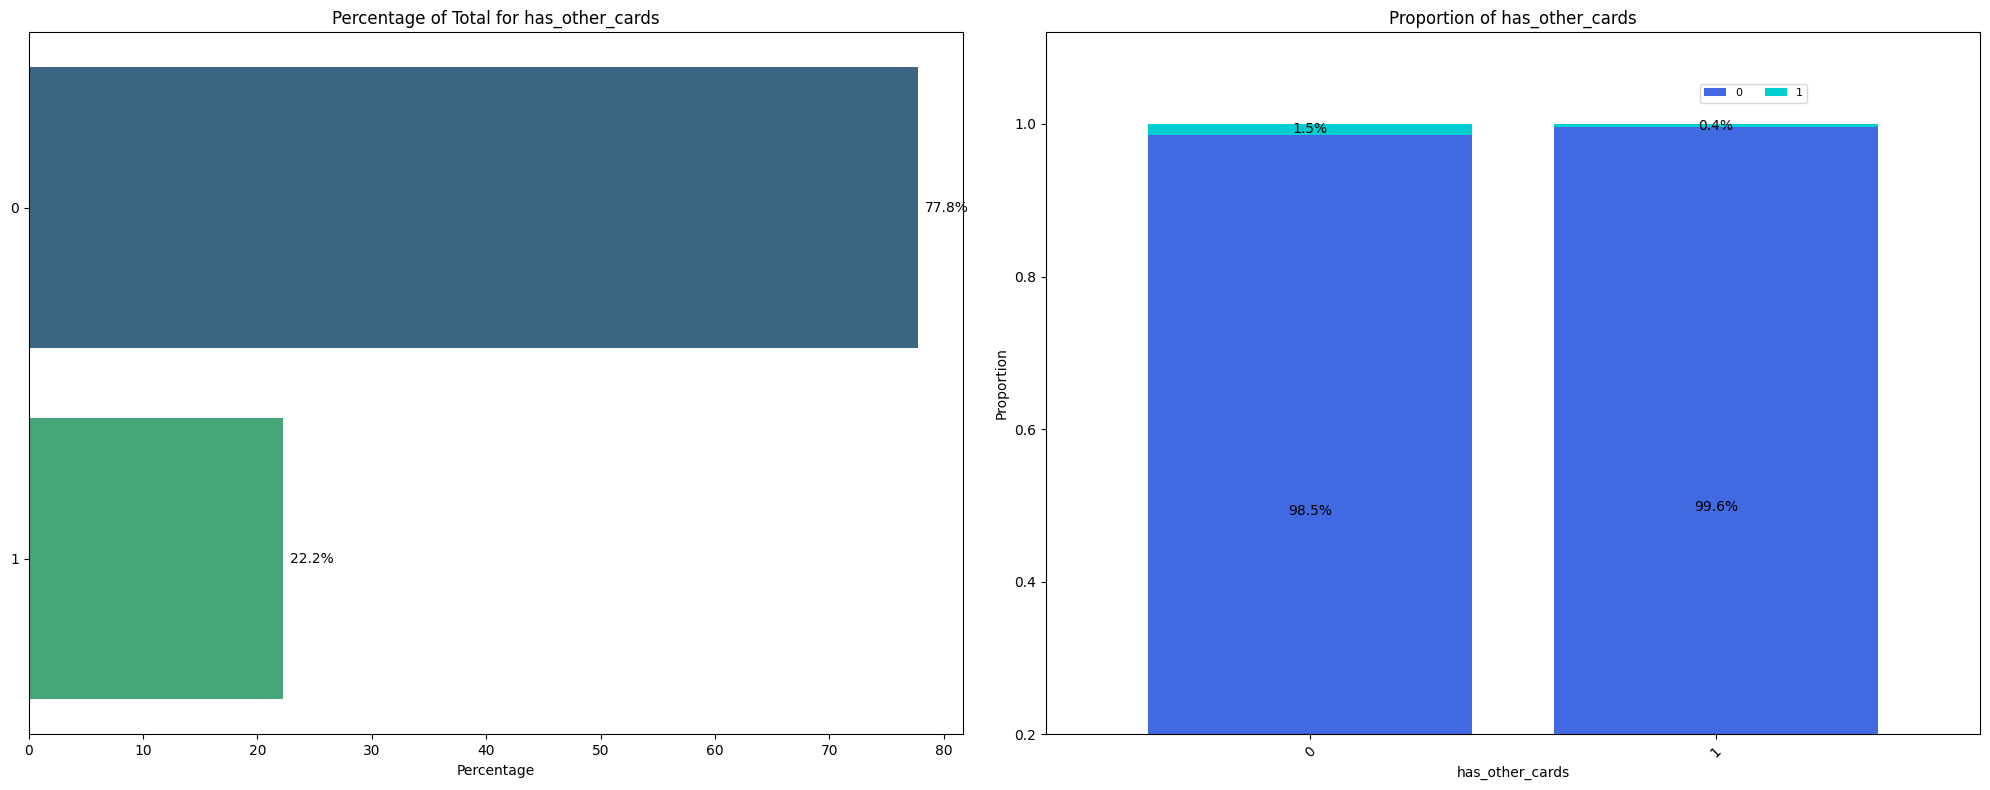

proposed_credit_limit

Applicant’s proposed credit limit. Ranges between [200, 2000].




,0
Feature,proposed_credit_limit
Missing Values,0
Correlation,0.046967


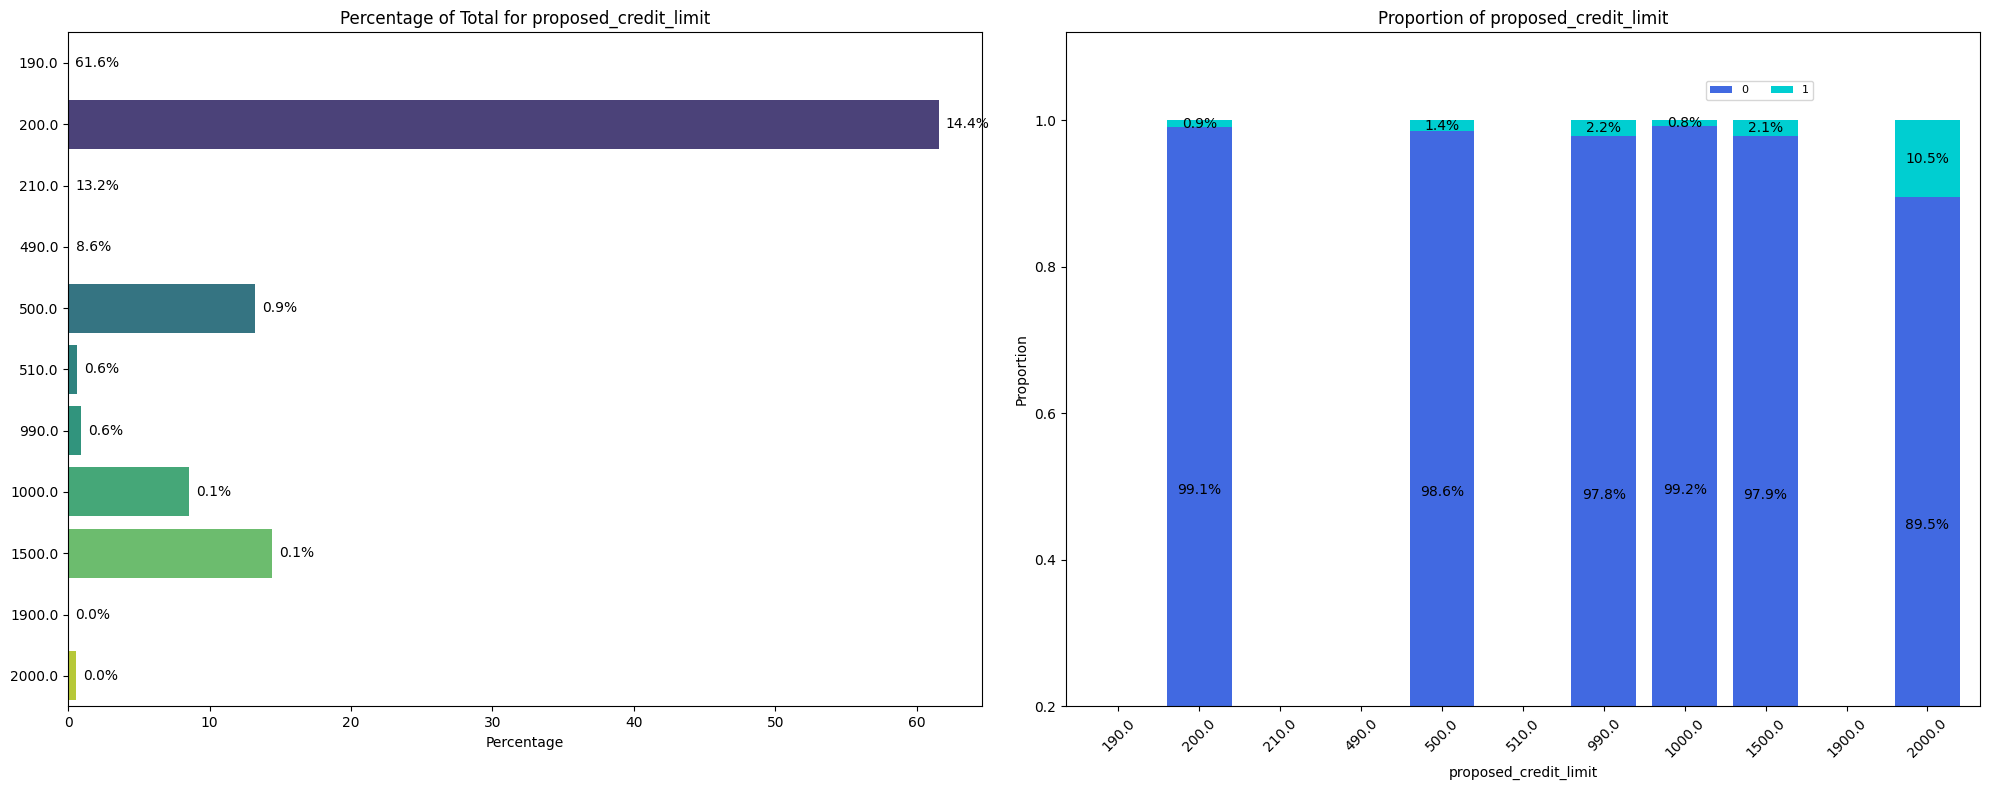

foreign_request

If origin country of request is different from bank’s country.




,0
Feature,foreign_request
Missing Values,0
Correlation,0.021787


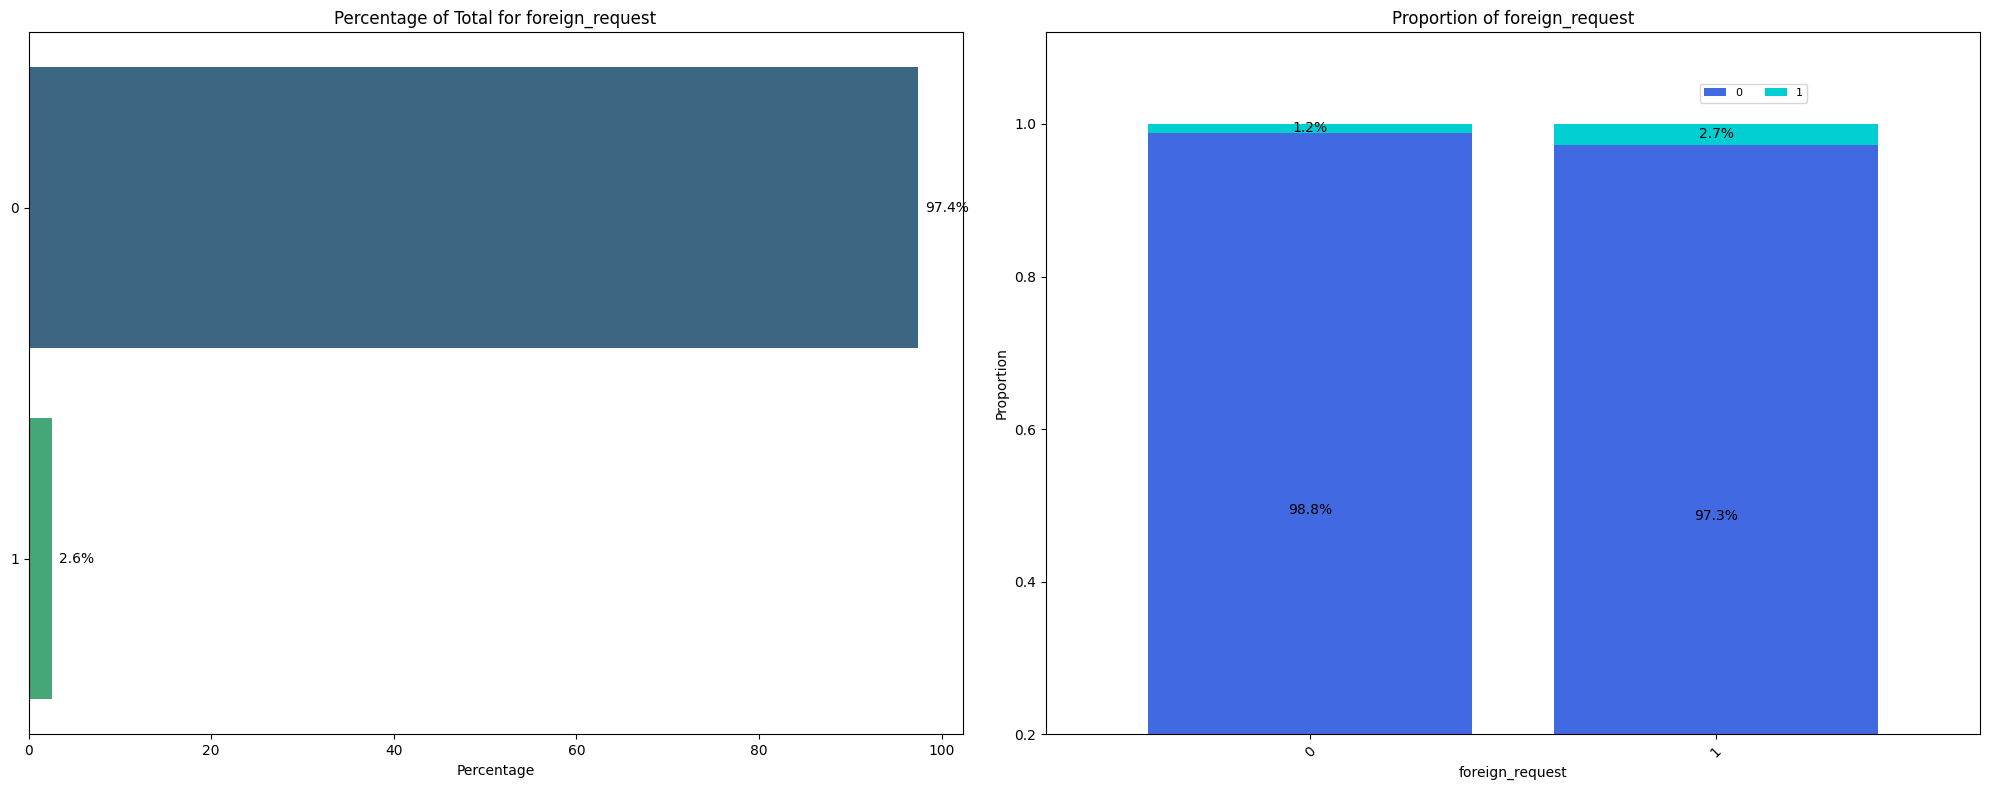

keep_alive_session

User option on session logout.




,0
Feature,keep_alive_session
Missing Values,0
Correlation,-0.036699


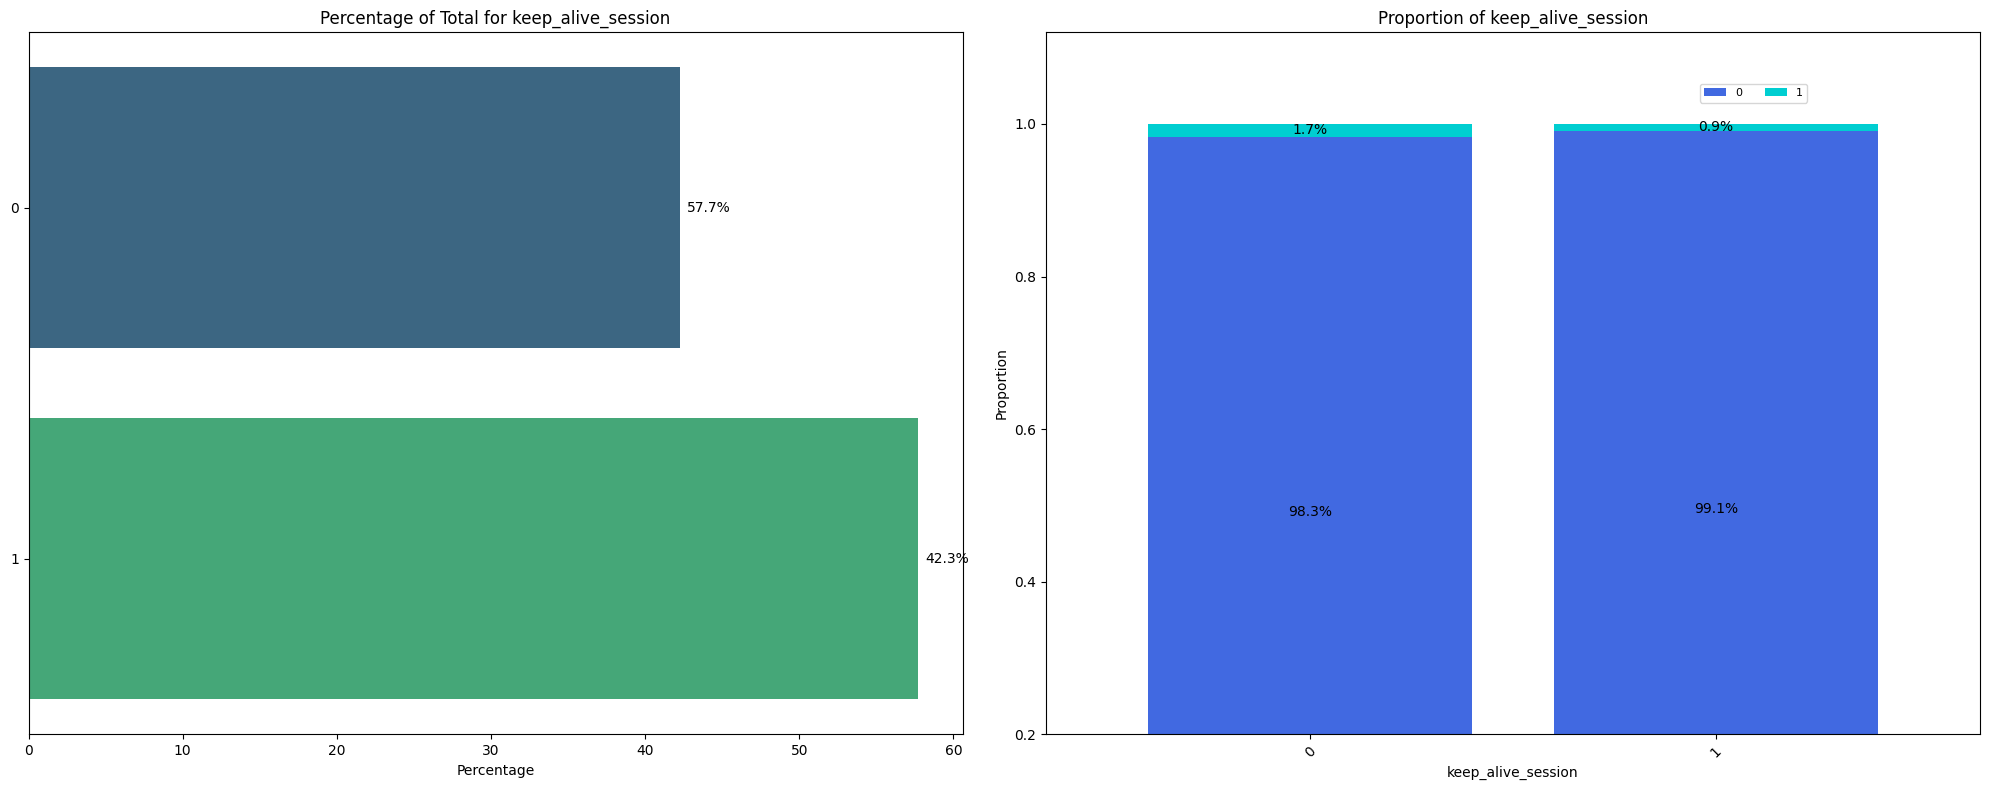

device_distinct_emails_8w

Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [−1, 2] emails (-1 is a missing value).




,0
Feature,device_distinct_emails_8w
Missing Values,6
Correlation,0.03885


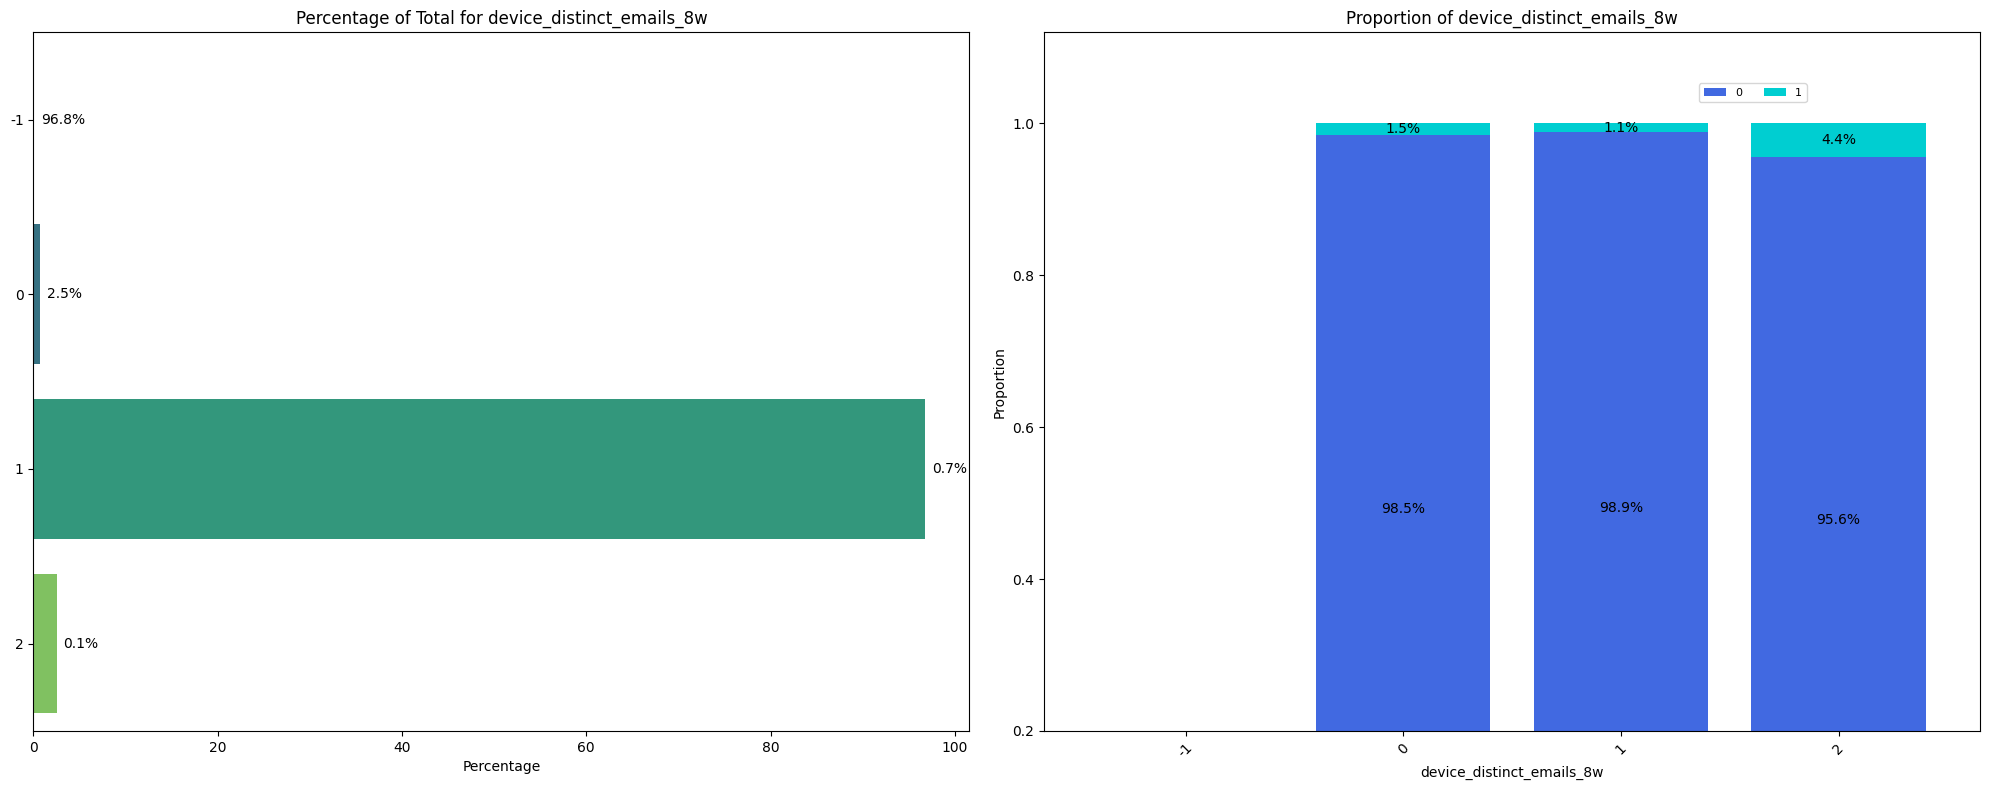

device_fraud_count

Number of fraudulent applications with used device. Ranges between [0, 1].




,0
Feature,device_fraud_count
Missing Values,0
Correlation,NaN


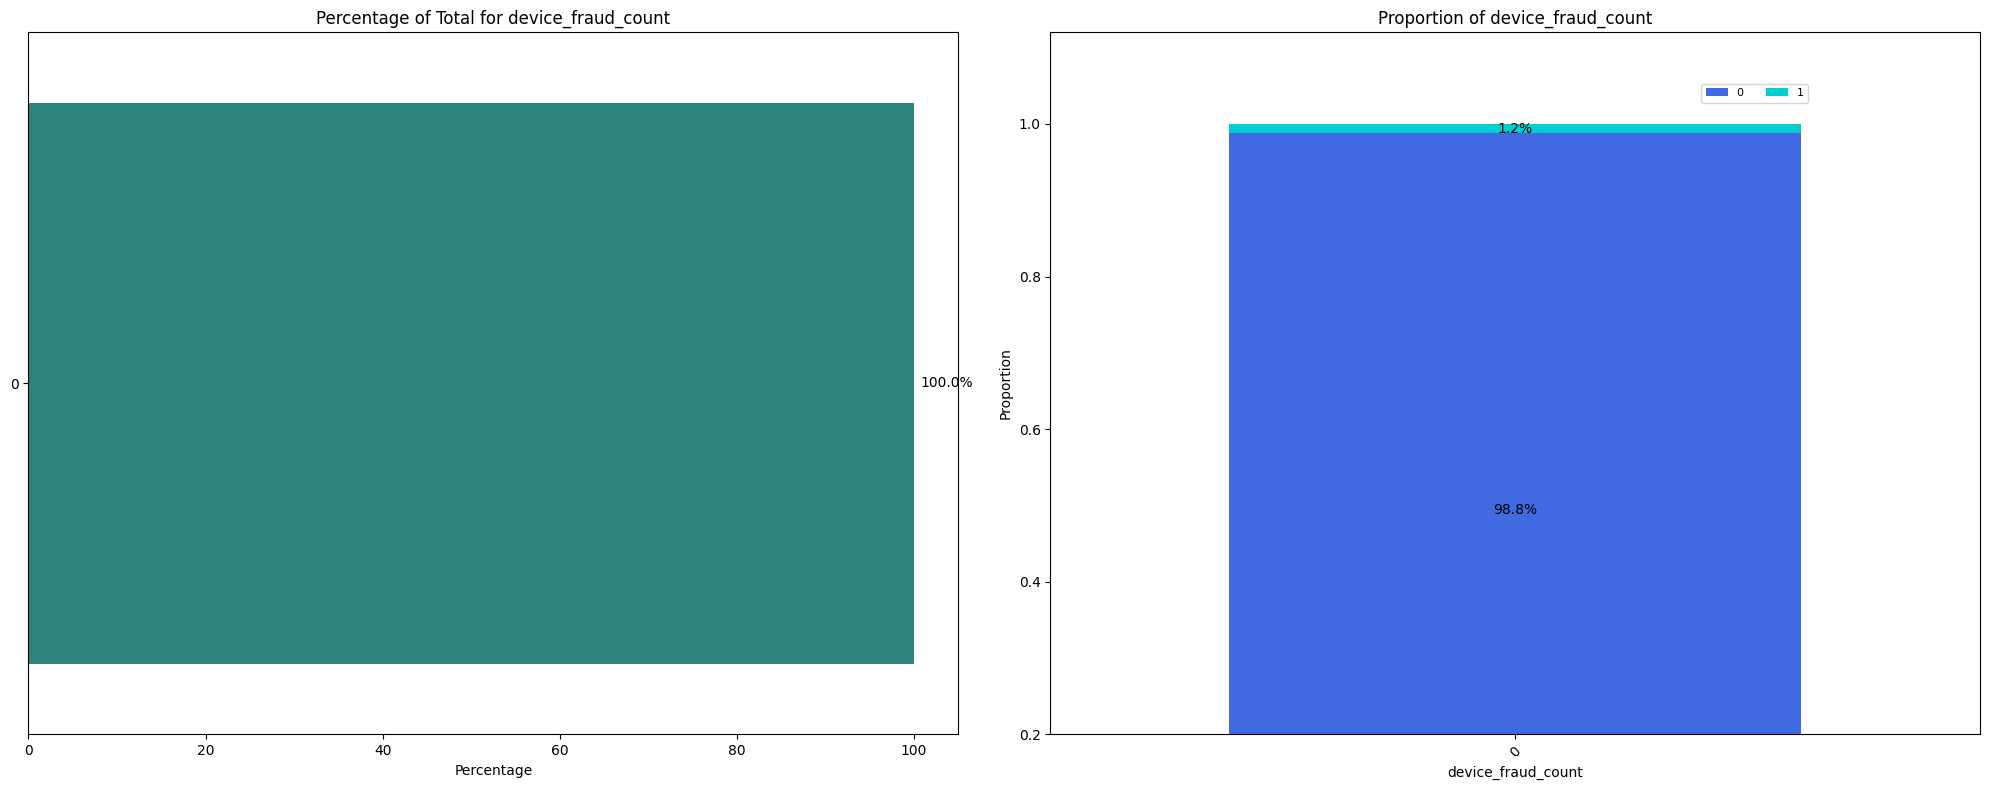

month

Month where the application was made. Ranges between [0, 7].




,0
Feature,month
Missing Values,0
Correlation,0.023317


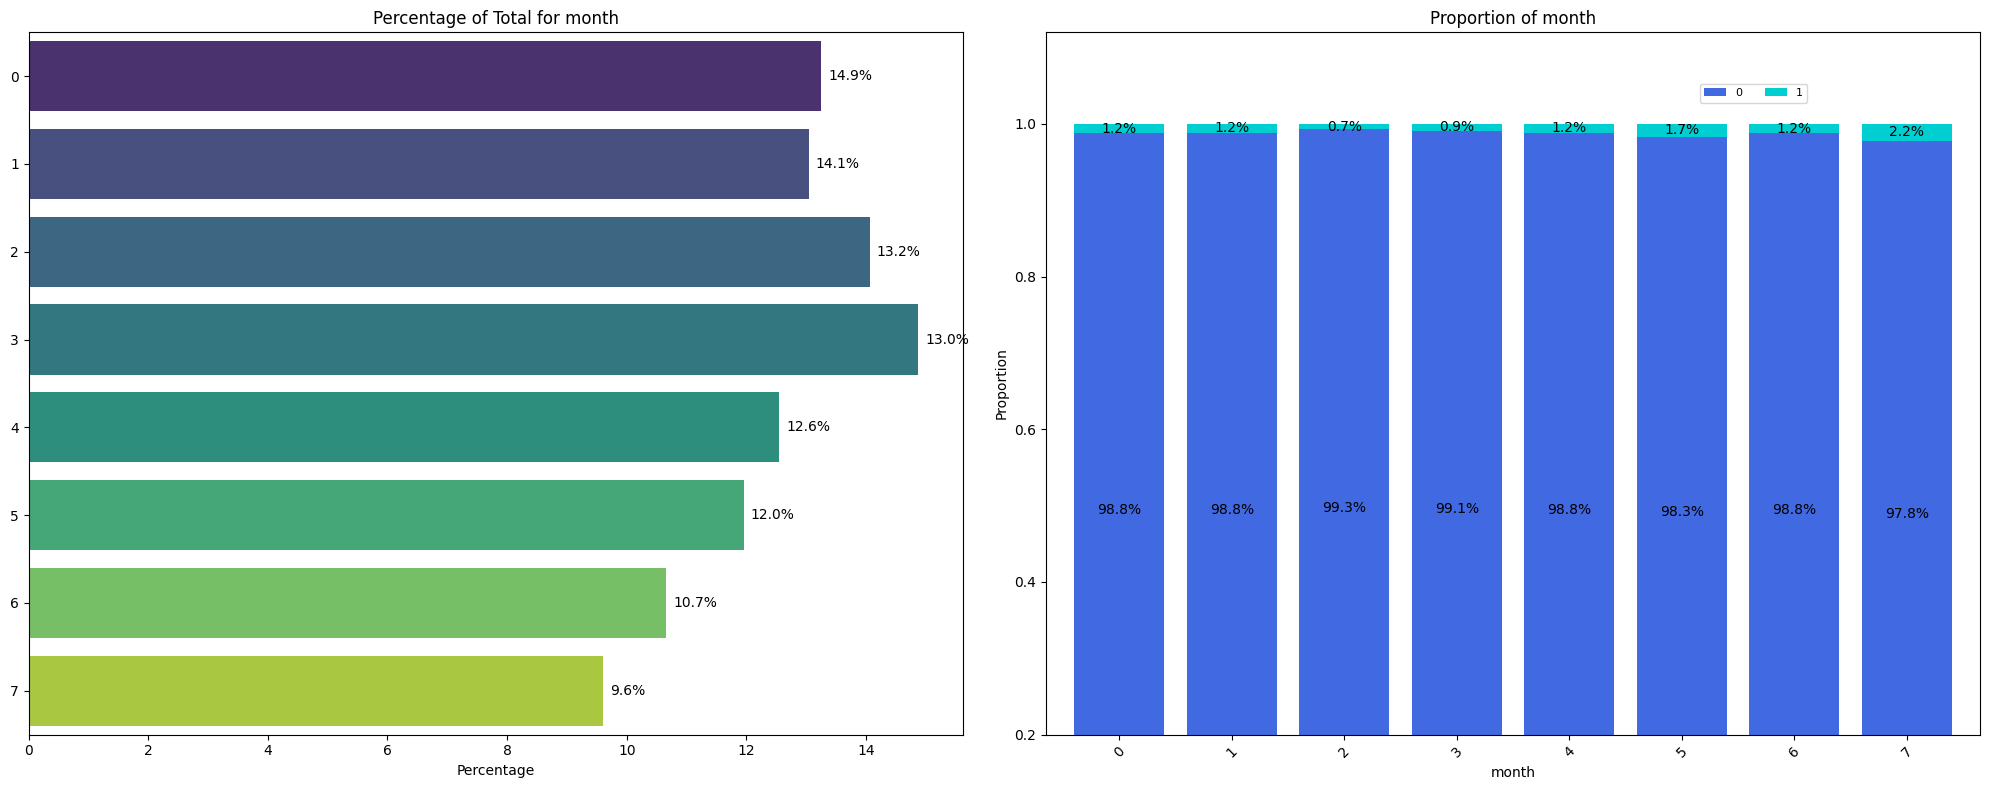

In [15]:
def eda_categorical(feats):
    for col in feats:
        feature_stats = []
        missing_values = len(base_encoded[base[col] == -1])
        correlation = base_encoded.corr()['fraud_bool'][col]

        feature_stats.append({
            'Feature': col,
            'Missing Values': missing_values,
            'Correlation': correlation
        })

        description = feature_descriptions[col]

        print(f'\033[1m{col}\033[0m\n\n{description}\n\n')

        base_stats = pd.DataFrame(feature_stats).T
        display(base_stats)

        # Setting up the subplots side by side
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

        # Plotting horizontal bar plots on the first axis
        value_counts = base[col].value_counts()
        percent_total = value_counts / sum(value_counts) * 100
        bars = sns.barplot(x=percent_total.values, y=percent_total.index, ax=ax1, palette='viridis', orient='h')

        # Annotating the bars with percentage values
        for bar, perc in zip(bars.patches, percent_total.values):
            ax1.annotate(f'{perc:.1f}%',
                         xy=(bar.get_width(), bar.get_y() + bar.get_height() / 2),
                         xytext=(5, 0),  # 5 points horizontal offset
                         textcoords='offset points',
                         ha='left', va='center')

        ax1.set_title(f'Percentage of Total for {col}')
        ax1.set_xlabel('Percentage')
        ax1.set_ylabel('')

        # Plotting the stacked bar plot on the second axis
        cmp = ListedColormap(['royalblue', 'darkturquoise'])
        percent_of_total = base_encoded.groupby([col, target_feat]).size().unstack()
        for i in range(len(percent_of_total)):
            percent_of_total.iloc[i,:] = percent_of_total.iloc[i,:] / sum(percent_of_total.iloc[i,:])

        bars = percent_of_total.plot(kind='bar', ax=ax2, stacked=True, width=0.8, colormap=cmp, legend=False, ylabel='Proportion')
        for bar_container in bars.containers:
            for bar in bar_container:
                height = bar.get_height()
                ax2.annotate(f'{height:.1%}',
                             xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2),
                             xytext=(0, 0),  # No offset
                             textcoords="offset points",
                             ha='center', va='center', fontsize=10, color='black')
        ax2.set_title(f'Proportion of {col}')
        ax2.legend(loc=(0.7, 0.9), fontsize=8, ncol=2)
        ax2.set_ylim([0.2, 1.12])
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

        # Adjust layout
        plt.tight_layout()

        # Show plot
        plt.show()


warnings.filterwarnings('ignore')
eda_categorical(cat_feats+disc_feats)

In [16]:
#Strip leading and trailing whitespace from all columns
base_clean = base.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# Replace '?' with NaN and remove rows with NaN values
base_clean = base_clean.replace('?', pd.NA).dropna()
base_clean[cont_feats] = base_clean[cont_feats].replace(-1, pd.NA).dropna()

base_clean.shape

(10000, 32)

## Feature Engineering

In [17]:
# DataFrames based on the condition
df1 = base_stats[base_stats['Correlation'] < -0.01]
df2 = base_stats[base_stats['Correlation'] > 0.01]

# Concatenate the DataFrames
result = pd.concat([df1, df2], ignore_index=True)
result

,Feature,Missing Values,Mean,Standard Deviation,Minimum,Maximum,Median,Correlation
0,name_email_similarity,0,0.490636,0.287560,0.000104,0.999989,0.485970,-0.021206
1,prev_address_months_count,7085,16.285100,42.583224,-1.000000,350.000000,-1.000000,-0.036180
2,intended_balcon_amount,0,8.631497,20.097488,-12.895097,110.995814,-0.838988,-0.025321
3,velocity_6h,0,5652.157818,3027.249679,116.573995,16356.364000,5295.228686,-0.024523
4,velocity_4w,0,4858.560015,917.378550,2983.337427,6988.564717,4918.337969,-0.021925
5,bank_branch_count_8w,0,181.716400,455.342572,0.000000,2380.000000,9.000000,-0.025007
6,date_of_birth_distinct_emails_4w,0,9.527000,5.060853,0.000000,37.000000,9.000000,-0.055545
7,current_address_months_count,54,89.754900,91.310294,-1.000000,400.000000,54.000000,0.034650
8,credit_risk_score,6,131.372600,70.426187,-148.000000,377.000000,122.000000,0.050427
9,session_length_in_minutes,24,7.442889,7.705412,-1.000000,71.410979,5.092229,0.023780


In [18]:
result['Feature']

,Feature
0,name_email_similarity
1,prev_address_months_count
2,intended_balcon_amount
3,velocity_6h
4,velocity_4w
5,bank_branch_count_8w
6,date_of_birth_distinct_emails_4w
7,current_address_months_count
8,credit_risk_score
9,session_length_in_minutes


In [19]:
drop_columns = ['velocity_24h','days_since_request','zip_count_4w','bank_months_count','session_length_in_minutes','source','device_fraud_count']

for col in drop_columns:
    base_encoded.drop(col, axis=1, inplace=True)
base_encoded.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,intended_balcon_amount,payment_type,velocity_6h,velocity_4w,...,housing_status,phone_home_valid,phone_mobile_valid,has_other_cards,proposed_credit_limit,foreign_request,device_os,keep_alive_session,device_distinct_emails_8w,month
276826,0,0.1,0.771248,-1,192,20,-1.050951,1,6079.874351,5339.732229,...,4,0,1,0,1500.0,0,3,0,1,2
849425,0,0.9,0.868609,-1,8,30,-0.683337,1,1727.733739,3582.755084,...,2,1,1,1,200.0,0,0,1,1,6
504499,0,0.6,0.461974,30,8,30,-0.916832,1,1108.075600,4936.787227,...,2,1,0,0,500.0,0,0,0,1,3
601054,0,0.9,0.388111,31,2,50,-0.817218,1,3849.725772,4872.355833,...,0,0,1,1,1500.0,0,3,1,1,4
980221,0,0.9,0.512189,-1,249,50,-0.230889,1,3282.921660,3150.353836,...,0,0,0,1,500.0,0,2,1,1,7


In [20]:
base_encoded.columns

Index(['fraud_bool', 'income', 'name_email_similarity',
       'prev_address_months_count', 'current_address_months_count',
       'customer_age', 'intended_balcon_amount', 'payment_type', 'velocity_6h',
       'velocity_4w', 'bank_branch_count_8w',
       'date_of_birth_distinct_emails_4w', 'employment_status',
       'credit_risk_score', 'email_is_free', 'housing_status',
       'phone_home_valid', 'phone_mobile_valid', 'has_other_cards',
       'proposed_credit_limit', 'foreign_request', 'device_os',
       'keep_alive_session', 'device_distinct_emails_8w', 'month'],
      dtype='object')

In [21]:
X = base_encoded.drop(target_feat, axis=1)
y = base_encoded[target_feat]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8000, 24)
(2000, 24)
(8000,)
(2000,)


## Classification Algorithms

### Logistic Regression

In [20]:
lr_clf = LogisticRegression(random_state=42)
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
lr_score = lr_clf.score(X_test, y_test)
print(f'accuracy score for Logistic Regression: {lr_score:.4f}')

accuracy score for Logistic Regression: 0.9875


In [31]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(X_train, y_train)
y_pred_rnd = rnd_clf.predict(X_test)
rnd_score = rnd_clf.score(X_test, y_test)
print(f'accuracy score for Random Forest: {rnd_score:.4f}')

accuracy score for Random Forest: 0.9895


In [ ]:
svc_clf = SVC(random_state=42)
svc_clf.fit(X_train, y_train)
y_pred_rnd = svc_clf.predict(X_test)
svc_score = svc_clf.score(X_test, y_test)
print(f'accuracy score for SVC: {svc_score:.4f}')

accuracy score for SVC: 0.9900


In [ ]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)
nb_score = nb_clf.score(X_test, y_test)
print(f'accuracy score for Naive Bayes: {nb_score:.4f}')

accuracy score for Naive Bayes: 0.9325


In [ ]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
nb_score = gb_clf.score(X_test, y_test)
print(f'accuracy score for Gradient Boosting: {nb_score:.4f}')

accuracy score for Gradient Boosting: 0.9885


In [ ]:

from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
import networkx as nx


# Define the Hill Climbing Search algorithm with BIC scoring
# Estimate the structure of the Bayesian Network
hc = HillClimbSearch(base_encoded)
best_model = hc.estimate(scoring_method=BicScore(base_encoded))


  0%|          | 0/1000000 [00:00<?, ?it/s]

Edges of the Estimated DAG:
[('fraud_bool', 'device_os'), ('fraud_bool', 'income'), ('fraud_bool', 'keep_alive_session'), ('fraud_bool', 'bank_months_count'), ('fraud_bool', 'has_other_cards'), ('fraud_bool', 'phone_home_valid'), ('fraud_bool', 'employment_status'), ('fraud_bool', 'device_distinct_emails_8w'), ('fraud_bool', 'customer_age'), ('fraud_bool', 'foreign_request'), ('customer_age', 'date_of_birth_distinct_emails_4w'), ('customer_age', 'employment_status'), ('customer_age', 'phone_mobile_valid'), ('customer_age', 'phone_home_valid'), ('payment_type', 'has_other_cards'), ('email_is_free', 'fraud_bool'), ('email_is_free', 'device_os'), ('email_is_free', 'foreign_request'), ('housing_status', 'fraud_bool'), ('housing_status', 'customer_age'), ('housing_status', 'proposed_credit_limit'), ('housing_status', 'email_is_free'), ('phone_home_valid', 'has_other_cards'), ('phone_mobile_valid', 'phone_home_valid'), ('bank_months_count', 'payment_type'), ('proposed_credit_limit', 'month')

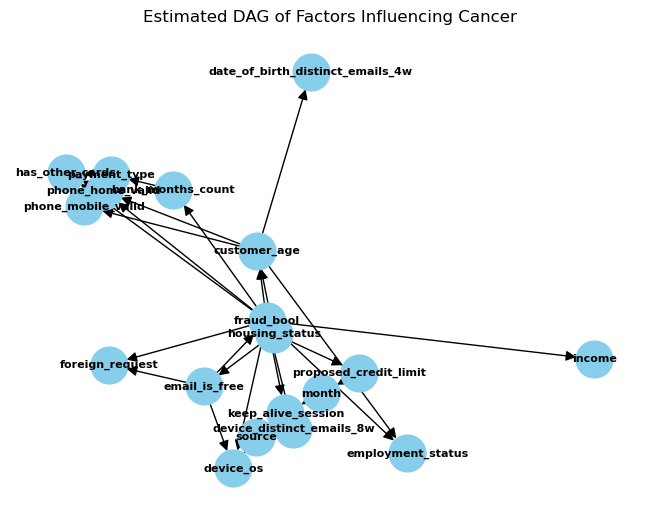

In [ ]:
# Print the edges of the estimated DAG
print("Edges of the Estimated DAG:")
print(best_model.edges())

# Draw the DAG
edges = best_model.edges()
G = nx.DiGraph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, arrowsize=15)
plt.title("Estimated DAG of Factors Influencing Cancer")
plt.show()

## Anomaly Detection

In [22]:
def displayReport(clf_name, y, y_pred):
    # Adjust y_pred to match binary classification format
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != y).sum()
    print(f"{clf_name}: {n_errors}")
    print("Accuracy Score :")
    print(accuracy_score(y, y_pred))
    print('Classification Report: ')
    print(classification_report(y, y_pred))

In [26]:
# Define the parameter grid
param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1,2],
    'contamination': [0.05, 0.1]
}


# Define parameter grid for Isolation Forest
param_grid_if = {
    'n_estimators': [50, 100, 200],
    'max_samples': ['auto', 0.5, 0.75, 1.0],
    'contamination': [0.01, 0.05, 0.1, 0.2],
    'max_features': [1.0, 0.5, 0.75],
    'bootstrap': [False, True]
}

# Define parameter grid for OneClassSVM
param_grid_svm = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'nu': [0.01, 0.05, 0.1, 0.5]
}

# Custom scoring function
def custom_scorer(y_true, y_pred):
    y_pred = np.where(y_pred == 1, 0, 1)
    return accuracy_score(y_true, y_pred)

# Make scorer
scorer = make_scorer(custom_scorer)

### Local Outlier Factor

In [27]:
warnings.filterwarnings('ignore')
# Initialize the model
lof = LocalOutlierFactor(novelty=True)
# Perform Grid Search
grid_search = GridSearchCV(estimator=lof, param_grid=param_grid_lof, scoring=scorer, cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final model with best parameters
best_lof = LocalOutlierFactor(**best_params)
y_pred = best_lof.fit_predict(X)
displayReport('Local Outlier', y, y_pred)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Local Outlier: 609
Accuracy Score :
0.9391
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      9877
           1       0.01      0.06      0.02       123

    accuracy                           0.94     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.94      0.96     10000



### Isolation Forest

In [28]:
# Initialize the model
clf_if = IsolationForest(random_state=42, verbose=0)

grid_search_if = GridSearchCV(estimator=clf_if, param_grid=param_grid_if, scoring=scorer, cv=5, n_jobs=-1)
grid_search_if.fit(X, y)


# Get the best parameters and best score
best_params_if = grid_search_if.best_params_
best_score_if = grid_search_if.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Score: {best_score}")

# Train the final Isolation Forest model with best parameters
best_isolation_forest = IsolationForest(**best_params_if, random_state=42)
y_pred_if = best_isolation_forest.fit_predict(X)
displayReport('Isolation Forest',y, y_pred_if)

Best Parameters: {'algorithm': 'auto', 'contamination': 0.05, 'leaf_size': 20, 'metric': 'euclidean', 'n_neighbors': 10, 'p': 1}
Best Score: nan
Isolation Forest: 219
Accuracy Score :
0.9781
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9877
           1       0.02      0.02      0.02       123

    accuracy                           0.98     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
# Standardize features for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

one_class_svm = OneClassSVM(max_iter=-1)

# Perform Grid Search for OneClassSVM
grid_search_svm = GridSearchCV(estimator=one_class_svm, param_grid=param_grid_svm, scoring=scorer, cv=5, n_jobs=-1)
grid_search_svm.fit(X_scaled, y)
best_params_svm = grid_search_svm.best_params_
best_score_svm = grid_search_svm.best_score_
warnings.filterwarnings('ignore')

print(f"Best Parameters for OneClassSVM: {best_params_svm}")
print(f"Best Score for OneClassSVM: {best_score_svm}")

# Train the final OneClassSVM model with best parameters
best_one_class_svm = OneClassSVM(**best_params_svm, max_iter=-1)
y_pred_svm = best_one_class_svm.fit_predict(X_scaled)
displayReport('One class SVM',y, y_pred_svm)

## Clustering

In [ ]:

neigh = KNeighborsClassifier(n_jobs=-1)

k=np.array([1,3,5,7,9,11,13,15,17,19,21,25,29,33,55]) # Different k values
tuned_parameters = {'n_neighbors' : k} # k values in a dictionary


clf = GridSearchCV(neigh, tuned_parameters, cv=5, scoring='roc_auc',return_train_score=True)
clf.fit(X_train, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)

#  gridsearchcv execution will understand. concepts required KFold cross validation
results = results.sort_values(['param_n_neighbors'])

train_auc= results['mean_train_score']

cv_auc = results['mean_test_score']

k =  results['param_n_neighbors']



plt.plot(k, train_auc, label='Train AUC')# to connect lines to auc points


plt.plot(k, cv_auc, label='CV AUC')



plt.scatter(k, train_auc, label='Train AUC points')
plt.scatter(k, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("log alpha base 10: hyperparameter")
plt.ylabel("AUC")
plt.title("ROCAUC Vs LOG Alpha plot")
plt.grid()
plt.show()


print(clf.best_params_)# pick the best alpha value
print(clf.best_score_)


In [ ]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

neigh = KNeighborsClassifier(n_neighbors=55)
neigh.fit(X_train, y_train)



y_train_pred = neigh.predict_proba(X_train)[:,1]
y_test_pred = neigh.predict_proba(X_test)[:,1]
#print(y_test_pred)
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC PLOT")
plt.grid()
plt.show()


def bestthreshold(threshould, fpr, tpr):# function to predict best threshold
    t = threshould[np.argmax(tpr*(1-fpr))]

    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predictusingbestt(proba, threshould):#prediction using best threshold
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

print("---------------------------------------------------")


from sklearn.metrics import confusion_matrix
best_t = bestthreshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")

ax = sns.heatmap(confusion_matrix(y_train, predictusingbestt(y_train_pred, best_t)),annot=True,fmt='d')
ax.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()
print("Test confusion matrix")


bx=sns.heatmap(confusion_matrix(y_test, predictusingbestt(y_test_pred, best_t)),annot=True,fmt='d')
bx.set_ylim([0,2])

plt.ylabel('actual values')
plt.xlabel('predicted values')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming df is your DataFrame
X = base.drop(columns=['fraud_bool'])
y = base['fraud_bool']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model (assuming GaussianNB for simplicity)
model = GaussianNB()
model.fit(X_train, y_train)


In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))


In [ ]:
# Feature importance can be approximated by looking at the mean and variance of each feature for each class
import numpy as np

feature_importance = np.exp(model.theta_[1]) - np.exp(model.theta_[0])
important_features = np.argsort(feature_importance)[::-1]

print("Important features in predicting fraud:")
for i in important_features:
    print(X.columns[i], ":", feature_importance[i])
